In [1]:
import pandas as pd
import scipy.io
from os import listdir
from sklearn.utils import shuffle
from sklearn import preprocessing
from nilearn import plotting
#from proteus.io import util
from proteus.visu import sbp_visu

import glob,os
import nibabel as nib


import pickle
from proteus.predic import high_confidence_at
import numpy as np
import pandas as pd
from proteus.predic import prediction
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from copy import deepcopy

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def stats_mask(y_true, y_pred, mask_selected=None):
    if mask_selected is None:
        mask_selected = np.ones(y_pred.shape).astype(bool)
    print('------------------------')
    print('Ratio:', y_true[mask_selected].sum()/y_true.sum()) 
    print('#    : ', y_true[mask_selected].sum()) 
    print('# true values: ',mask_selected.sum())
    print('ACC  : ', np.mean((y_true == y_pred)[mask_selected])) 

In [3]:
def predic_stats(y_, y_pred, lr_decision):
    # number of AD subjects
    n_ad = sum(y_)
    print('Total number of TARGET subjects: ', n_ad)

    # number of CN subjects
    n_cn = len(y_) - sum(y_)
    print('Total number of NON-TARGET subjects: ', n_cn)
    
    # number of subjects predicted as AD at stage 1
    n_pos = sum(y_pred)
    print('Stage 1 number of hits (true and false positives): ', n_pos)
    
    # true positives at stage 1
    n_pos_ad = sum(y_pred[y_.astype(bool)])
    print('Stage 1 TRUE positives: ', n_pos_ad)
    
    # false positives at stage 1
    n_pos_cn = n_pos - n_pos_ad
    print('Stage 1 FALSE positives: ', n_pos_cn)
    
    # number of CN subjects not identified as positive (true negatives)
    n_neg1_cn = n_cn - n_pos_cn
    print('Stage 1 TRUE negatives: ', n_neg1_cn)

    # number of all flagged HPC-AD subjects
    n_flag = sum(y_pred[lr_decision>0])
    print('Total number of flagged HPC-AD subjects: ', n_flag)

    # number of flagged HPC-AD subjects who are actually AD (true positives)
    n_flag_ad = sum(y_[lr_decision>0])
    print('Number of flagged HPC-AD subjects that are TRUE positives: ', n_flag_ad)

    # number of flagged HPC-AD subjects that are actually CN (false positives)
    n_flag_cn = n_flag - n_flag_ad
    print('Number of flagged HPC-AD subjects that are FALSE positives: ', n_flag_cn)

    # number of CN subjects that were not flagged (true negatives)
    n_neg_cn = n_cn - n_flag_cn
    print('Number of true negatives: ', n_neg_cn)
    
    print('#############################')
    print('Stage 1 stats for TARGET vs NON-TARGET')
    print('Precision for AD: ', n_pos_ad/(n_pos_ad + n_pos_cn))
    prec = n_pos_ad/(n_pos_ad + n_pos_cn)
    print('Recall (or sensitivity)  for AD: ', n_pos_ad/n_ad)
    sens = n_pos_ad/n_ad
    print('Specificity: ', n_neg1_cn/n_cn)
    spec = n_neg1_cn/n_cn
    fp = (1-spec)*664
    tp = sens*336
    adj_prec = tp/(tp+fp)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec)
    print('Accuracy: ', (n_pos_ad + n_neg1_cn)/(n_ad + n_cn))
    acc = (n_pos_ad + n_neg1_cn)/(n_ad + n_cn)

    print('#############################')
    print('Stage 2 stats for TARGET vs NON-TARGET')
    print('Precision for HPC-AD: ', n_flag_ad/n_flag)
    prec_2 = n_flag_ad/n_flag
    print('Recall (or sensitivity) for HPC-AD: ', n_flag_ad/n_ad)
    sens_2 = n_flag_ad/n_ad
    print('Specificity: ', n_neg_cn/n_cn)
    spec_2 = n_neg_cn/n_cn
    fp_2 = (1-spec_2)*664
    tp_2 = sens_2*336
    adj_prec_2 = tp_2/(tp_2 + fp_2)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec_2)
    print('Accuracy: ', (n_flag_ad + n_neg_cn)/(n_ad + n_cn))
    acc_2 = (n_flag_ad + n_neg_cn)/(n_ad + n_cn)
    
    return sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2

In [4]:
def hpc_df(dataframe, y_pred, lr_decision):
    # make mask out of flagged subjects
    mask_flag_hpc = lr_decision>0
    # stack the predicted values and mask so we can put it into a dataframe
    pred = np.stack((y_pred,mask_flag_hpc),axis=1)
    # make dataframe
    flag_df = pd.DataFrame(data=pred, columns=['f_s1','f_hpc'])
    # add flag status to dataframe, so we can see which subjects have been flagged
    dataframe['f_s1'] = flag_df['f_s1'].values
    dataframe['f_hpc'] = flag_df['f_hpc'].values
    # create labels based on flags at stage 1 and stage 2
    for i,row in dataframe.iterrows():
        s1 = row[dataframe.columns.get_loc("f_s1")]
        hp = row[dataframe.columns.get_loc("f_hpc")]
        if s1 == 0 and hp == 0: 
            dataframe.ix[i,'flag_status'] = 'Negative'
        if s1 == 1 and hp == 0:
            dataframe.ix[i,'flag_status'] = 'Non-HPS+'
        if hp == 1:
            dataframe.ix[i,'flag_status'] = 'HPS+'
    # create dummy variables based on flags
    for i,row in dataframe.iterrows():
        flag = row[dataframe.columns.get_loc("flag_status")]
        if flag == 'Negative':
            dataframe.ix[i, 'f_neg'] = 1
            dataframe.ix[i, 'f_s1_only'] = 0
        if flag == 'Non-HPS+':
            dataframe.ix[i, 'f_neg'] = 0
            dataframe.ix[i, 'f_s1_only'] = 1
        if flag == 'HPS+':
            dataframe.ix[i, 'f_neg'] = 0
            dataframe.ix[i, 'f_s1_only'] = 0
    # create labels for diagnosis and flags
    try:
        for i,row in dataframe.iterrows():
            flag = row[dataframe.columns.get_loc("flag_status")]
            dx = row[dataframe.columns.get_loc("DX")]
            conv_ad = row[dataframe.columns.get_loc("conv_2_ad")]
            if flag == 'Negative':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'CN-'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'sMCI-'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'pMCI-'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'AD-'
            if flag == 'Non-HPS+':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'CN+'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'sMCI+'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'pMCI+'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'AD+'
            if flag == 'HPS+':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ CN'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ sMCI'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ pMCI'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ AD'
    except:
        pass

In [5]:
# function to calculate ratios for a binary variable of interest (voi) between the target and non-target groups
def compare_ratio_var(dataframe, voi, target_grp):
    
    # number of Abeta+ CN subjects
    a = dataframe[dataframe['%s'%target_grp]==0]['%s'%voi].sum()
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe['%s'%target_grp]==0))])
    print('baseline rate in NON-TARGET subjects: ', a/b)

    print('#'*10)
    # number of Abeta+ AD subjects
    a = dataframe[dataframe['%s'%target_grp]==1]['%s'%voi].sum()
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe['%s'%target_grp]==1))])
    print('baseline rate in TARGET subjects: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in the whole sample
    a = dataframe['%s'%voi].sum()
    print('number of subjects with VOI in the whole sample: ', a)

    # total number of subjects with amyloid data in whole sample
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]))])
    print('total number of subjects with VOI data in whole sample: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects that are positive at stage 1 (including HPC)
    a = dataframe[dataframe.f_s1==1]['%s'%voi].sum()
    print('number of subjects with VOI that are positive at stage 1: ', a)

    # total number of positive stage 1 subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_s1==1))])
    print('total number of positive stage 1 subjects with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in HPC-AD
    a = dataframe[dataframe.f_hpc==1]['%s'%voi].sum()
    print('number of subjects with VOI in HPC-AD: ', a)

    # total number of HPC-AD subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_hpc==1))])
    print('total number of HPC-AD subjects with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in Non-HPC+
    a = dataframe[dataframe.f_s1_only==1]['%s'%voi].sum()
    print('number of subjects with VOI in Non-HPC+: ', a)

    # total number of Non-HPC+ with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_s1_only==1))])
    print('total number of Non-HPC+ with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in negative subjects
    a = dataframe[dataframe.f_neg==1]['%s'%voi].sum()
    print('number of subjects with VOI in negative subjects: ', a)

    # total number of negative subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_neg==1))])
    print('total number of negative subjects with VOI data', b)

    print('ratio: ', a/b)

In [6]:
def chi2_fn(dataframe, voi):
    
    neg = dataframe[dataframe.flag_status == 'Negative']['%s'%voi].dropna()
    pos = dataframe[dataframe.flag_status == 'Non-HPS+']['%s'%voi].dropna()
    pos_hpc = dataframe[dataframe.flag_status == 'HPS+']['%s'%voi].dropna()
    data = {'%s'%voi: ['-','+'],
           'Negative': [len(neg)-sum(neg), sum(neg)],
           'Non-HPS+': [len(pos)-sum(pos), sum(pos)],
           'HPS+': [len(pos_hpc)-sum(pos_hpc), sum(pos_hpc)]}
    df = pd.DataFrame(data, columns={'%s'%voi, 'Negative', 'Non-HPS+', 'HPS+'})
    obs = df.as_matrix(columns=['Negative', 'Non-HPS+', 'HPS+'])
    chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
    print('observed freq: ')
    print(obs)
    print('Chi2: ', chi2)
    print('p value: ', p)
    print('degress of freedom: ', dof)
    print('expected freq: ')
    print(exf)
    
    return df

In [7]:
def hpc_pie(df, voi, filename):
    plt.close()
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    ax1.pie(df['Negative'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax1.set_title('Negatives')
    ax1.set(adjustable='box-forced', aspect='equal')
    ax2.pie(df['Non-HPS+'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax2.set_title('Non-HPS+')
    ax2.set(adjustable='box-forced', aspect='equal')
    ax3.pie(df['HPS+'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax3.set_title('HPS+')
    ax3.set(adjustable='box-forced', aspect='equal')
    #plt.subplots(1, 3, subplot_kw={'aspect':'equal'})
    #plt.close()
    plt.show()
    fig.savefig(filename)

In [8]:
def anova_hpc(df, voi, ymin, ymax, filename):
    #sns.set_style('white')
    neg = df[df.flag_status == 'Negative']["%s"%voi].dropna()
    pos = df[df.flag_status == 'Non-HPS+']["%s"%voi].dropna()
    pos_hpc = df[df.flag_status == 'HPS+']["%s"%voi].dropna()
    f, p = scipy.stats.f_oneway(neg,pos,pos_hpc)
    # boxplot of weights across groups
    x_order = ['Negative','Non-HPS+', 'HPS+']
    # set figure size
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.boxplot(x="flag_status", y="%s"%voi, data=df, fliersize=0, order=x_order, palette='Greys')
    sns.swarmplot(x="flag_status",y="%s"%voi,data=df, color="0.2", size=6, order=x_order)
    plt.ylim(ymin, ymax)
    plt.show()
    fig.savefig(filename)
    print('ANOVA F: ', f)
    print('p value: ', p)
    
    # do pairwise post hoc tests
    tmp_df = df.dropna(axis=0, how='any', subset=['%s'%voi])
    print(pairwise_tukeyhsd(tmp_df['%s'%voi], tmp_df['flag_status']))

In [9]:
def anova_hpc_split(df, voi, ymin, ymax, grp1, grp2, filename):
    #sns.set_style('white')    
    neg1 = df[df.flag_dx == '%s-'%grp1]["%s"%voi].dropna()
    pos1 = df[df.flag_dx == '%s+'%grp1]["%s"%voi].dropna()
    pos_hpc1 = df[df.flag_dx == 'HPS+ %s'%grp1]["%s"%voi].dropna()
    
    neg2 = df[df.flag_dx == '%s-'%grp2]["%s"%voi].dropna()
    pos2 = df[df.flag_dx == '%s+'%grp2]["%s"%voi].dropna()
    pos_hpc2 = df[df.flag_dx == 'HPS+ %s'%grp2]["%s"%voi].dropna()
    
    f, p = scipy.stats.f_oneway(neg1,pos1,pos_hpc2,neg2,pos2,pos_hpc1)
    # boxplot of weights across groups
    x_order = ['%s-'%grp1, '%s+'%grp1, 'HPS+ %s'%grp1,'%s-'%grp2, '%s+'%grp2, 'HPS+ %s'%grp2]
    # set figure size
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.boxplot(x="flag_dx", y="%s"%voi, data=df, fliersize=0, order=x_order)
    sns.swarmplot(x="flag_dx",y="%s"%voi,data=df, color="0.2", size=5, edgecolor='gray', order=x_order)
    plt.ylim(ymin, ymax)
    plt.show()
    fig.savefig(filename)
    print('ANOVA F: ', f)
    print('p value: ', p)
    
    # do pairwise post hoc tests
    #mask = df.loc[:,['%s'%grp1,'%s'%grp2]].values.sum(1).astype(bool)
    #m_df = df.iloc[mask]
    tmp_df = df.dropna(axis=0, how='any', subset=['%s'%voi])
    print(pairwise_tukeyhsd(tmp_df['%s'%voi], tmp_df['flag_dx']))

In [10]:
sns.set(font_scale=3)
sns.set_style("white")
#sns.set_context("paper")
#sns.set_palette("colorblind")
#sns.set_palette("GnBu_d")

#sns.set_palette(sns.cubehelix_palette(n_colors=8))
#sns.set_palette(sns.color_palette("BrBG", 6))

cpal = ["#F0DFB2", "#CFA255", "#995D12", "#B3E2DB", "#58B0A6", "#0D7068"]
sns.set_palette(cpal)


In [11]:
path_results = '/Users/AngelaTam/Desktop/adsf/cognitive_hpc_20180131/'

In [12]:
np.random.seed(1)

## Load longitudinal data 

In [13]:
long_data = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni_csv/adnimerge_upenn_unw_av45_neurobat.csv')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load data for the training set (ADNI1)

In [14]:
data = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_model_weights.csv')

In [15]:
data.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv', 'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],
            inplace=True)

In [16]:
data = data[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
            'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX',
            'sub1','sub2','sub3','sub4','sub5','sub6','sub7']]

# Organize the AD & CN data for classification task

In [17]:
# Mask of the CN and AD subjects only
mask_cnad = data.loc[:,['CN','AD']].values.sum(1).astype(bool)

In [18]:
#reload(high_confidence)
scalerX = preprocessing.StandardScaler()
scaler = preprocessing.StandardScaler()

x_ = data.iloc[mask_cnad,data.columns.get_loc("ADAS13"):data.columns.get_loc("CLOCKSCOR")+1].values
#x_ = scalerX.fit_transform(x_)
y_ = data[['AD']].values.ravel()[mask_cnad]

confounds = data[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_cnad,:]
#confounds[:, 1:] = scaler.fit_transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]

#crm = prediction.ConfoundsRm(confounds, x_)
#x_ = crm.transform(confounds, x_)

x_ = scaler.fit_transform(np.hstack((x_,confounds)))
#x_ = np.hstack((x_,confounds))


x_.shape, y_.shape, confounds.shape

((370, 9), (370,), (370, 4))

# Cross-validation HPC in ADNI1 AD & CN

In [19]:
scores_ad_cn=[]
scores_s2 = []
ad_precision = []
cn_precision = []
ad_recall = []
cn_recall = []
ad_f1_score = []
cn_f1_score = []

s1_spec = []
s1_sens = []
s1_prec = []
s1_acc = []

s2_spec = []
s2_sens = []
s2_prec = []
s2_acc = []

skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(x_,y_):
    X_training, X_val = x_[train_index], x_[val_index]
    y_training, y_val = y_[train_index], y_[val_index]
    
    hpc = high_confidence_at.TwoStagesPrediction(
        n_iter=500,
        shuffle_test_split=0.5,
        min_gamma=.99,
        thresh_ratio=0.1)
    
    hpc.fit(X_training, X_training, y_training)
    
    _, dic_results = hpc.predict(X_val, X_val)
    
    # test in validation sample
    acc = metrics.accuracy_score(y_val, (dic_results['s1df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2df'][:,1]>0)
    acc_s2 = metrics.accuracy_score(y_val[tmp_mask], (dic_results['s1df'][:,0]>0).astype(float)[tmp_mask])
    scores_ad_cn.append(acc)
    scores_s2.append(acc_s2)
    print('Classifying AD vs CN...')
    print((dic_results['s1df'][:,0]>0).astype(float))
    
    y_pred = (dic_results['s1df'][:,0]>0).astype(float)
    lr_decision = dic_results['s2df'][:,1]
    
    ad_p = metrics.precision_score(y_val, y_pred)
    ad_precision.append(ad_p)
    cn_p = metrics.precision_score(y_val, y_pred, pos_label=0)
    cn_precision.append(cn_p)
    ad_r = metrics.recall_score(y_val, y_pred)
    ad_recall.append(ad_r)
    cn_r = metrics.recall_score(y_val, y_pred, pos_label=0)
    cn_recall.append(cn_r)
    ad_f1 = metrics.f1_score(y_val, y_pred)
    ad_f1_score.append(ad_f1)
    cn_f1 = metrics.f1_score(y_val, y_pred, pos_label=0)
    cn_f1_score.append(cn_f1)
    
    sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2 = predic_stats(y_val, y_pred, lr_decision)
    s1_spec.append(spec)
    s1_sens.append(sens)
    s1_prec.append(prec)
    s1_acc.append(acc)
    s2_spec.append(spec_2)
    s2_sens.append(sens_2)
    s2_prec.append(prec_2)
    s2_acc.append(acc_2)

Stage 1
Proba:
[ 1.          1.          1.          1.          1.          0.98755187
  1.          1.          1.          1.          0.87649402  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.99595142  1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.9958159   1.          0.98387097
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.     

#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  1.0
Recall (or sensitivity) for HPC-AD:  0.818181818182
Specificity:  1.0
Adjusted precision for 33.6% baseline rate:  1.0
Accuracy:  0.918699186992
Stage 1
Proba:
[ 0.54581673  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.91696751  0.97107438  0.99578059
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.99190283  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  0.76893939  1.          0.65863454  1.          1.          1.          1.
  1.          1.          1.          1.          1.   

In [20]:
print('Stage 1')
print('Mean sensitivity: ', np.mean(s1_sens))
print('Mean specificity: ', np.mean(s1_spec))
print('Mean precision: ', np.mean(s1_prec))
print('Mean accuracy: ', np.mean(s1_acc))
print('#'*10)
print('Stage 2')
print('Mean sensitivity: ', np.mean(s2_sens))
print('Mean specificity: ', np.mean(s2_spec))
print('Mean precision: ', np.mean(s2_prec))
print('Mean accuracy: ', np.mean(s2_acc))

Stage 1
Mean sensitivity:  0.963636363636
Mean specificity:  0.980463199773
Mean precision:  0.976469312514
Mean accuracy:  0.972987149226
##########
Stage 2
Mean sensitivity:  0.872727272727
Mean specificity:  1.0
Mean precision:  1.0
Mean accuracy:  0.943242416295


# Train HPC (on whole training set of ADNI1 AD & CN)

In [21]:
#reload(high_confidence)
hpc = high_confidence_at.TwoStagesPrediction(
    n_iter=500,
    shuffle_test_split=0.5,
    min_gamma=.99,
    thresh_ratio=0.1)

hpc.fit(x_, x_, y_)

Stage 1
Proba:
[ 0.70416667  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.9766537   0.95454545  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  0.97165992  1.          0.36        1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  0.47983871  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          0.63052209  1.          1.
  0.1284

In [22]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  165.0
# true values:  370
ACC  :  0.975675675676
Level 2
------------------------
Ratio: 0.909090909091
#    :  150.0
# true values:  150
ACC  :  1.0


In [23]:
hpc.confidencemodel.clfs[1].coef_

array([[  5.48773151e+00,  -4.80181720e+00,  -2.50194908e+00,
          1.27849222e+00,  -2.59256065e-01,  -1.42281108e-01,
         -1.32957294e-03,  -3.34408473e-01,   2.38175334e-01]])

In [24]:
# plot weights from the model
w_df = pd.DataFrame(data=np.transpose(hpc.confidencemodel.clfs[1].coef_),columns=['Coefficient'])
w_df['Factor'] = ['ADAS13','MEM','EXEC','BNT','CLOCK','sex','age','GMV','TIV']

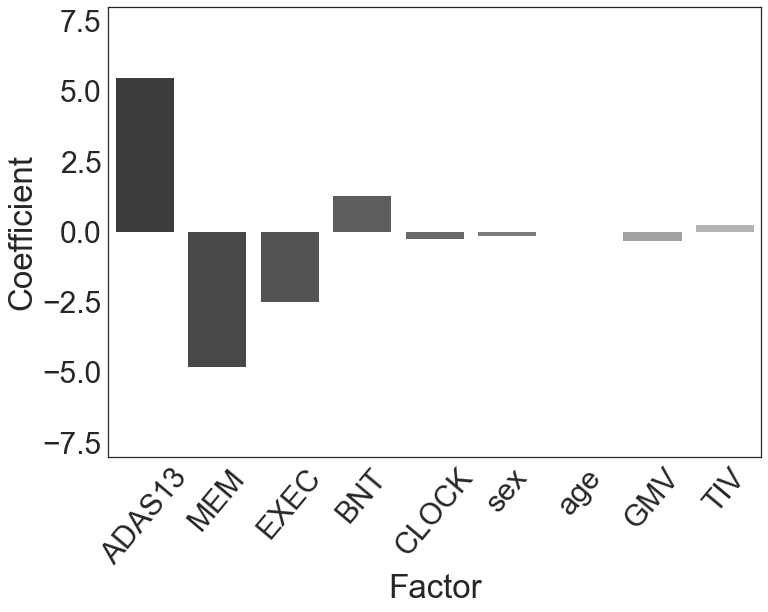

In [25]:
#sns.set(font_scale=2)
#sns.set_style('white')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

#fig,ax = plt.subplots(figsize=(11.7, 8.27))
sns.factorplot(ax=ax, y='Coefficient', x='Factor', data=w_df, kind='bar', palette="Greys_d")
#ax.set_xticklabels(rotation=50)
for item in ax.get_xticklabels():
    item.set_rotation(50)
ax.set_ylim(-8,8)
plt.close()
plt.show()
fig.savefig(path_results + 'weights_model.pdf',bbox_inches='tight')

In [26]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [27]:
print('Stage 1 stats for AD vs CN')
print(metrics.classification_report(y_, y_pred))

Stage 1 stats for AD vs CN
             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98       205
        1.0       0.98      0.97      0.97       165

avg / total       0.98      0.98      0.98       370



In [28]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  165.0
Total number of NON-TARGET subjects:  205.0
Stage 1 number of hits (true and false positives):  164.0
Stage 1 TRUE positives:  160.0
Stage 1 FALSE positives:  4.0
Stage 1 TRUE negatives:  201.0
Total number of flagged HPC-AD subjects:  150.0
Number of flagged HPC-AD subjects that are TRUE positives:  150.0
Number of flagged HPC-AD subjects that are FALSE positives:  0.0
Number of true negatives:  205.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.975609756098
Recall (or sensitivity)  for AD:  0.969696969697
Specificity:  0.980487804878
Adjusted precision for 33.6% baseline rate:  0.961755958614
Accuracy:  0.975675675676
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  1.0
Recall (or sensitivity) for HPC-AD:  0.909090909091
Specificity:  1.0
Adjusted precision for 33.6% baseline rate:  1.0
Accuracy:  0.959459459459


(0.96969696969696972,
 0.98048780487804876,
 0.97560975609756095,
 0.9756756756756757,
 0.90909090909090906,
 1.0,
 1.0,
 0.95945945945945943)

In [29]:
plt.hist(hpc.training_hit_probability,20)
plt.ylim(0,400)
plt.rcParams.update({'font.size': 18})

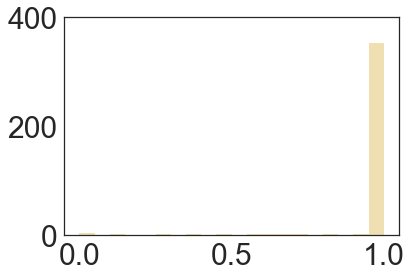

In [30]:
plt.show()

In [31]:
sum(hpc.training_hit_probability==1)

340

In [32]:
len(hpc.training_hit_probability)

370

In [33]:
sum(hpc.training_hit_probability!=1)

30

# characteristics of HPC-AD people in ADNI1 AD/CN

In [34]:
# copy data frame and mask
df1 = deepcopy(data)
df1 = df1[mask_cnad]

In [35]:
hpc_df(df1, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [36]:
long_df_adni1_adcn = pd.merge(long_data, df1[['RID','flag_dx','flag_status']], 
                              how='left', on=['RID'])

In [37]:
long_df_adni1_adcn.dropna(subset=['flag_status'],inplace=True)

In [38]:
long_df_adni1_adcn.reset_index(inplace=True, drop=True)

In [39]:
long_df_adni1_adcn.to_csv(path_results + 'adni1_adcn_hps.csv', index=False)

## APOE4 positivity in ADNI1 AD vs CN

In [40]:
compare_ratio_var(df1, 'APOE4_bin', 'AD')

baseline rate in NON-TARGET subjects:  0.2780487804878049
##########
baseline rate in TARGET subjects:  0.6545454545454545
##########
number of subjects with VOI in the whole sample:  165.0
total number of subjects with VOI data in whole sample:  370
ratio:  0.44594594594594594
##########
number of subjects with VOI that are positive at stage 1:  106.0
total number of positive stage 1 subjects with VOI data:  164
ratio:  0.6463414634146342
##########
number of subjects with VOI in HPC-AD:  100.0
total number of HPC-AD subjects with VOI data:  150
ratio:  0.6666666666666666
##########
number of subjects with VOI in Non-HPC+:  6.0
total number of Non-HPC+ with VOI data:  14
ratio:  0.42857142857142855
##########
number of subjects with VOI in negative subjects:  59.0
total number of negative subjects with VOI data 206
ratio:  0.28640776699029125


In [41]:
tmp_df = chi2_fn(df1, 'APOE4_bin')

observed freq: 
[[ 147.    8.   50.]
 [  59.    6.  100.]]
Chi2:  50.814173329
p value:  9.24362801996e-12
degress of freedom:  2
expected freq: 
[[ 114.13513514    7.75675676   83.10810811]
 [  91.86486486    6.24324324   66.89189189]]


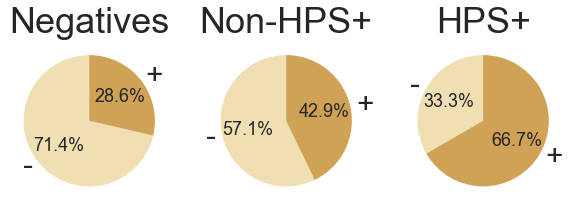

In [42]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_adcn_hpc_e4_pie.pdf')

In [43]:
# dataframe with just AD subjects
mask_ad = df1.loc[:,'AD'].values.astype(bool)
df1_ad = df1.iloc[mask_ad]

In [44]:
tmp_df = chi2_fn(df1_ad, 'APOE4_bin')

observed freq: 
[[   3.    4.   50.]
 [   2.    6.  100.]]
Chi2:  1.66179337232
p value:  0.435658462211
degress of freedom:  2
expected freq: 
[[  1.72727273   3.45454545  51.81818182]
 [  3.27272727   6.54545455  98.18181818]]


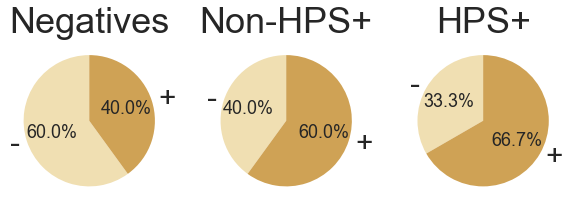

In [45]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_ad_hpc_e4_pie.pdf')

## sex in ADNI1 AD vs CN  (% male)

In [46]:
compare_ratio_var(df1, 'gender', 'AD')

baseline rate in NON-TARGET subjects:  0.48292682926829267
##########
baseline rate in TARGET subjects:  0.48484848484848486
##########
number of subjects with VOI in the whole sample:  179.0
total number of subjects with VOI data in whole sample:  370
ratio:  0.4837837837837838
##########
number of subjects with VOI that are positive at stage 1:  79.0
total number of positive stage 1 subjects with VOI data:  164
ratio:  0.4817073170731707
##########
number of subjects with VOI in HPC-AD:  75.0
total number of HPC-AD subjects with VOI data:  150
ratio:  0.5
##########
number of subjects with VOI in Non-HPC+:  4.0
total number of Non-HPC+ with VOI data:  14
ratio:  0.2857142857142857
##########
number of subjects with VOI in negative subjects:  100.0
total number of negative subjects with VOI data 206
ratio:  0.4854368932038835


In [47]:
chi2_fn(df1, 'gender')

observed freq: 
[[ 106.   10.   75.]
 [ 100.    4.   75.]]
Chi2:  2.35947851117
p value:  0.307358870263
degress of freedom:  2
expected freq: 
[[ 106.34054054    7.22702703   77.43243243]
 [  99.65945946    6.77297297   72.56756757]]


,HPS+,Negative,Non-HPS+,gender
0,75.0,106.0,10.0,-
1,75.0,100.0,4.0,+


## associations with vbm subtypes

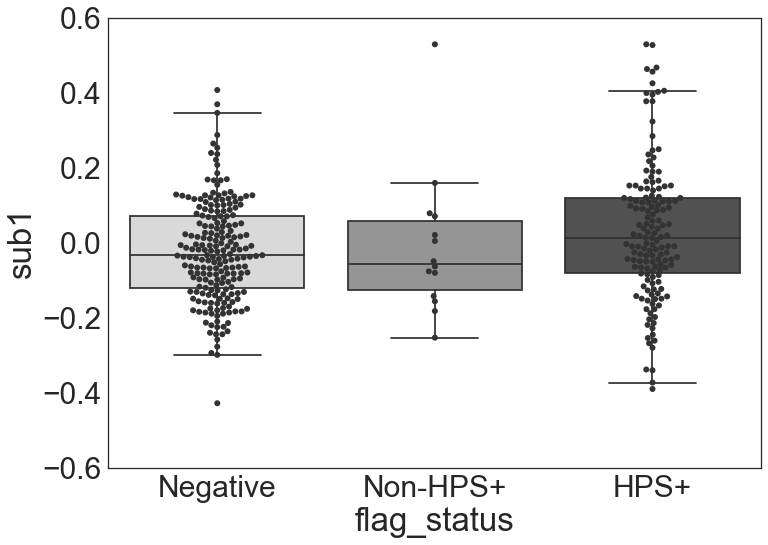

ANOVA F:  4.91096263326
p value:  0.00785663666842
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.0528  -0.0925 -0.0131  True 
  HPS+   Non-HPS+ -0.0393  -0.1427  0.0641 False 
Negative Non-HPS+  0.0134  -0.0887  0.1156 False 
-------------------------------------------------


In [48]:
anova_hpc(df1, 'sub1', -0.6, 0.6, path_results + 'adni1_adcn_sub1.pdf')

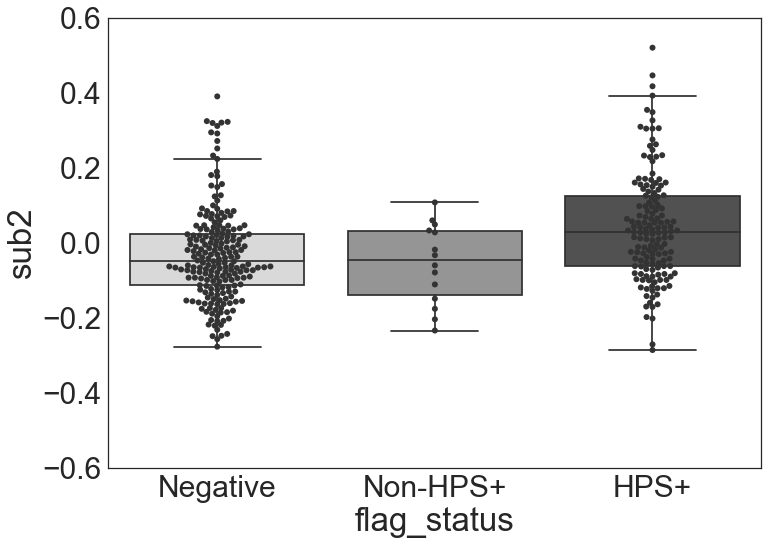

ANOVA F:  14.861707298
p value:  6.21878275225e-07
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.0742  -0.1076 -0.0408  True 
  HPS+   Non-HPS+ -0.0984  -0.1853 -0.0114  True 
Negative Non-HPS+ -0.0241  -0.1101  0.0618 False 
-------------------------------------------------


In [49]:
anova_hpc(df1, 'sub2', -0.6, 0.6, path_results + 'adni1_adcn_sub2.pdf')

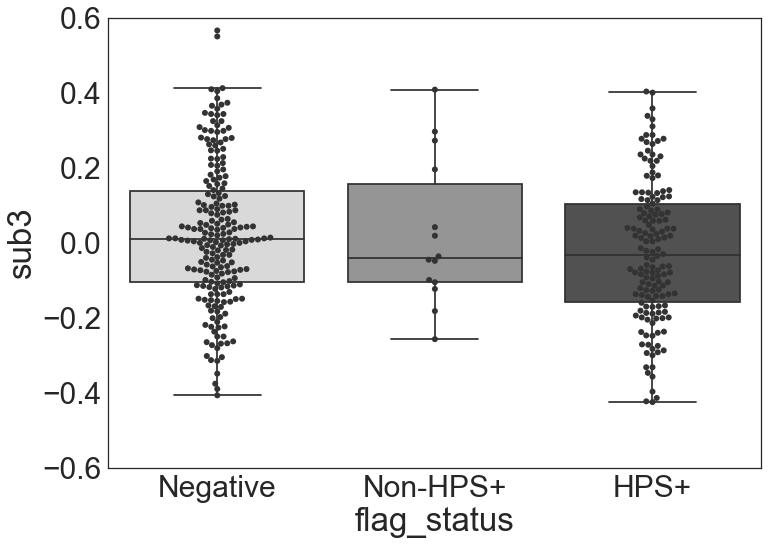

ANOVA F:  3.01129201155
p value:  0.0504460454441
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0489   0.0014 0.0963  True 
  HPS+   Non-HPS+  0.0487  -0.0749 0.1724 False 
Negative Non-HPS+ -0.0001  -0.1223 0.1221 False 
------------------------------------------------


In [50]:
anova_hpc(df1, 'sub3', -0.6, 0.6, path_results + 'adni1_adcn_sub3.pdf')

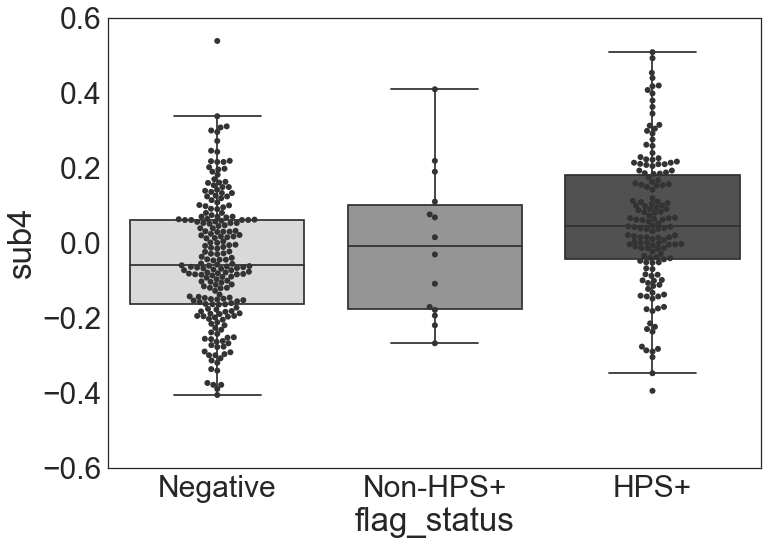

ANOVA F:  16.0172451069
p value:  2.1419431145e-07
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.1038  -0.1469 -0.0606  True 
  HPS+   Non-HPS+ -0.0649  -0.1772  0.0475 False 
Negative Non-HPS+  0.0389  -0.0721  0.1499 False 
-------------------------------------------------


In [51]:
anova_hpc(df1, 'sub4', -0.6, 0.6, path_results + 'adni1_adcn_sub4.pdf')

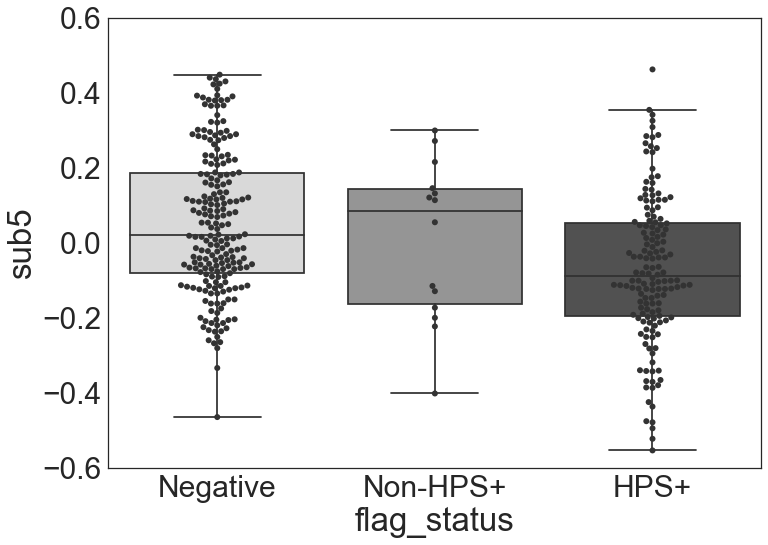

ANOVA F:  17.98527841
p value:  3.53646536743e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.1247   0.0757 0.1736  True 
  HPS+   Non-HPS+  0.0792  -0.0482 0.2066 False 
Negative Non-HPS+ -0.0454  -0.1713 0.0805 False 
------------------------------------------------


In [52]:
anova_hpc(df1, 'sub5', -0.6, 0.6, path_results + 'adni1_adcn_sub5.pdf')

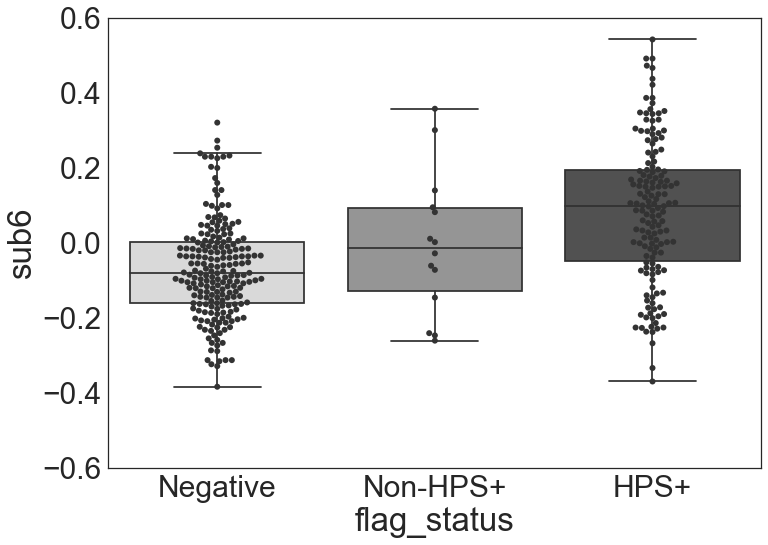

ANOVA F:  41.7817437768
p value:  4.48743066269e-17
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.1565  -0.1968 -0.1162  True 
  HPS+   Non-HPS+ -0.0902  -0.1951  0.0147 False 
Negative Non-HPS+  0.0664  -0.0373  0.1701 False 
-------------------------------------------------


In [53]:
anova_hpc(df1, 'sub6', -0.6, 0.6, path_results + 'adni1_adcn_sub6.pdf')

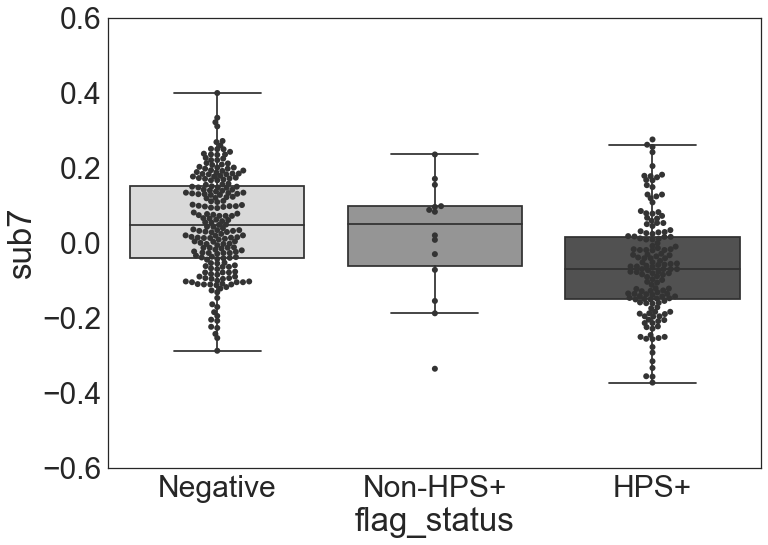

ANOVA F:  32.727842027
p value:  8.3356104333e-14
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff lower  upper  reject
-----------------------------------------------
  HPS+   Negative  0.115   0.0815 0.1484  True 
  HPS+   Non-HPS+  0.0761  -0.011 0.1632 False 
Negative Non-HPS+ -0.0389  -0.125 0.0472 False 
-----------------------------------------------


In [54]:
anova_hpc(df1, 'sub7', -0.6, 0.6, path_results + 'adni1_adcn_sub7.pdf')

## CSF tau in ADNI1 AD vs CN

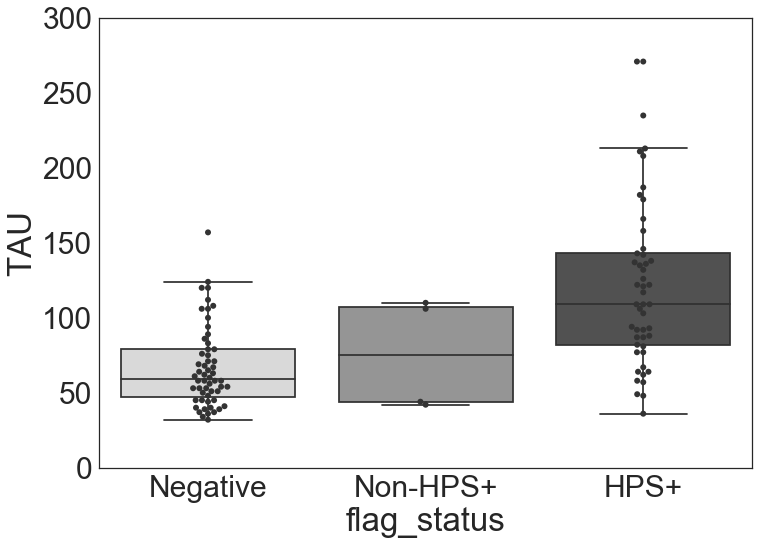

ANOVA F:  21.7926387513
p value:  1.18059715375e-08
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
 group1   group2  meandiff   lower    upper   reject
----------------------------------------------------
  HPS+   Negative -55.3673  -75.4454 -35.2893  True 
  HPS+   Non-HPS+ -46.7245 -100.0984  6.6494  False 
Negative Non-HPS+  8.6429   -44.4786 61.7644  False 
----------------------------------------------------


In [55]:
anova_hpc(df1, 'TAU', 0, 300, path_results + 'adni1_adcn_csf_tau.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


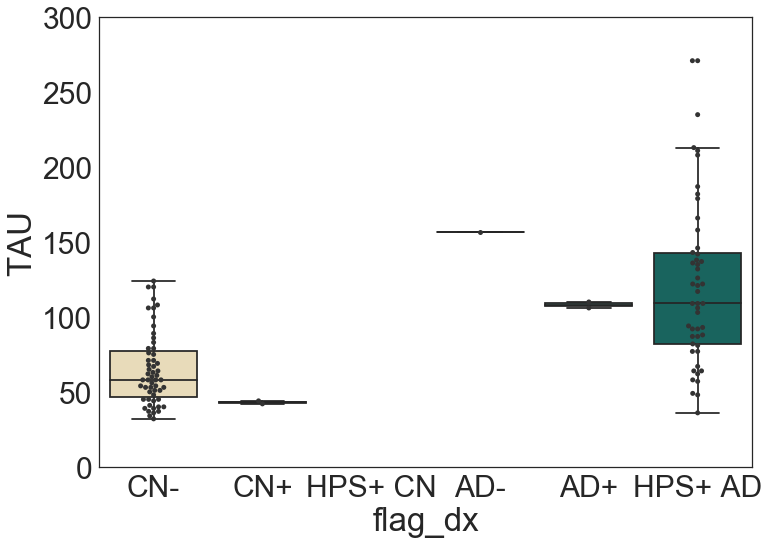

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff   lower    upper   reject
-------------------------------------------------
 AD+     AD-     49.0    -94.4506 192.4506 False 
 AD+     CN+    -65.0   -182.1269 52.1269  False 
 AD+     CN-   -42.7818 -127.0954 41.5318  False 
 AD+   HPS+ AD 14.2245   -70.2701 98.7191  False 
 AD-     CN+    -114.0  -257.4506 29.4506  False 
 AD-     CN-   -91.7818 -209.9687 26.4051  False 
 AD-   HPS+ AD -34.7755 -153.0916 83.5405  False 
 CN+     CN-   22.2182   -62.0954 106.5318 False 
 CN+   HPS+ AD 79.2245   -5.2701  163.7191 False 
 CN-   HPS+ AD 57.0063   33.9975  80.0151   True 
-------------------------------------------------


In [56]:
anova_hpc_split(df1, 'TAU', 0, 300, 'CN', 'AD', path_results + 'adni1_adcn_csf_tau_split.pdf')

## CSF abeta in ADNI1 AD vs CN 

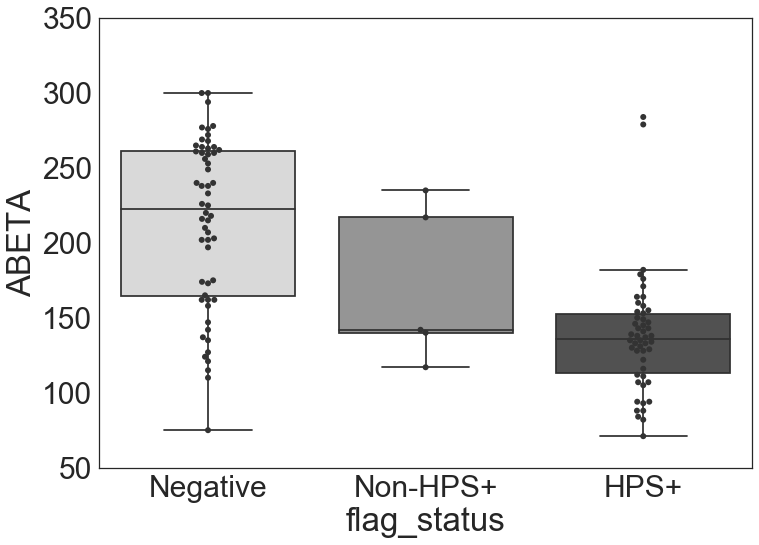

ANOVA F:  30.8030700049
p value:  2.60038706668e-11
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative 75.5857  52.6789  98.4925  True 
  HPS+   Non-HPS+   32.5   -22.7207 87.7207 False 
Negative Non-HPS+ -43.0857 -98.0369 11.8654 False 
--------------------------------------------------


In [57]:
anova_hpc(df1, 'ABETA', 50, 350, path_results + 'adni1_adcn_csf_abeta.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


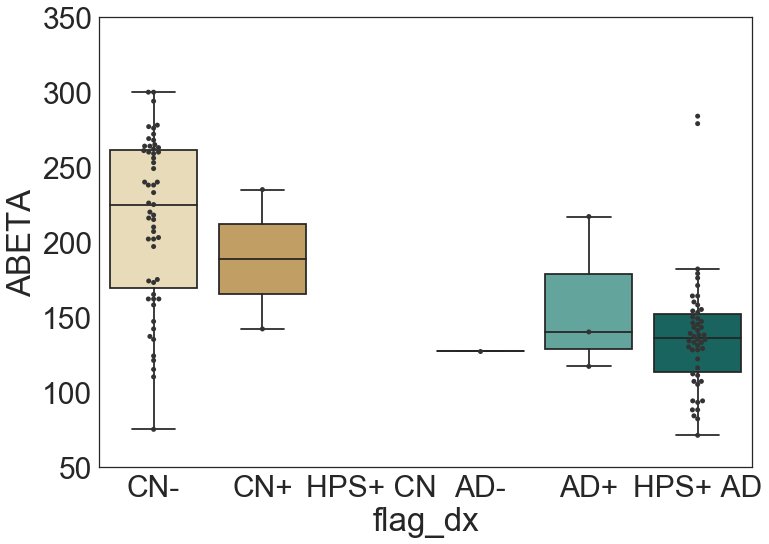

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff   lower    upper   reject
-------------------------------------------------
 AD+     AD-    -31.0   -188.5915 126.5915 False 
 AD+     CN+     30.5    -94.087  155.087  False 
 AD+     CN-   56.8545   -24.0617 137.7708 False 
 AD+   HPS+ AD  -20.3   -101.4252 60.8252  False 
 AD-     CN+     61.5   -105.6511 228.6511 False 
 AD-     CN-   87.8545   -49.8588 225.5679 False 
 AD-   HPS+ AD   10.7   -127.1363 148.5363 False 
 CN+     CN-   26.3545   -71.8891 124.5982 False 
 CN+   HPS+ AD  -50.8   -149.2159 47.6159  False 
 CN-   HPS+ AD -77.1545 -103.8226 -50.4865  True 
-------------------------------------------------


In [58]:
anova_hpc_split(df1, 'ABETA', 50, 350, 'CN', 'AD', path_results + 'adni1_adcn_csf_abeta_split.pdf')

## age in ADNI1 AD vs CN

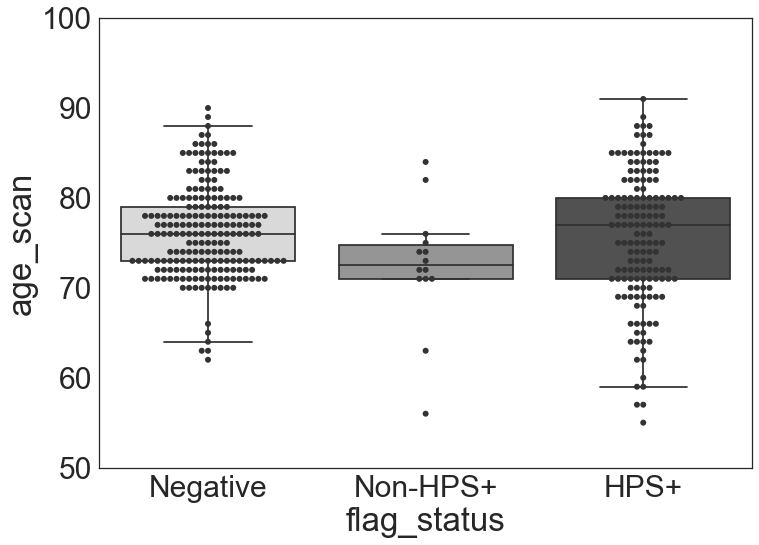

ANOVA F:  2.51693965511
p value:  0.0820985969888
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.602   -0.9659 2.1699 False 
  HPS+   Non-HPS+ -3.1248  -7.2069 0.9574 False 
Negative Non-HPS+ -3.7268  -7.7613 0.3077 False 
------------------------------------------------


In [59]:
anova_hpc(df1, 'age_scan', 50, 100, path_results + 'adni1_adcn_age.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


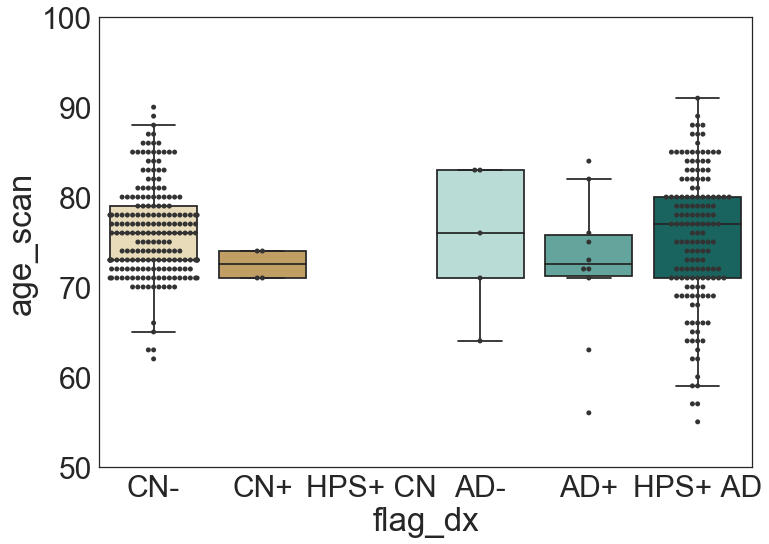

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff  lower    upper  reject
-----------------------------------------------
 AD+     AD-     3.0    -6.3449  12.3449 False 
 AD+     CN+     0.1    -9.9936  10.1936 False 
 AD+     CN-    3.7741  -1.7537   9.302  False 
 AD+   HPS+ AD  3.1533  -2.4189   8.7255 False 
 AD-     CN+     -2.9   -14.3451  8.5451 False 
 AD-     CN-    0.7741  -6.9503   8.4985 False 
 AD-   HPS+ AD  0.1533  -7.6029   7.9095 False 
 CN+     CN-    3.6741   -4.941  12.2893 False 
 CN+   HPS+ AD  3.0533  -5.5903   11.697 False 
 CN-   HPS+ AD -0.6208  -2.4617   1.2201 False 
-----------------------------------------------


In [60]:
anova_hpc_split(df1, 'age_scan', 50, 100, 'CN', 'AD', path_results + 'adni1_adcn_age_split.pdf')

# Test on ADNI1 MCI stable vs converters

In [61]:
# load the data
adni1_mci = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_mci_bl_demog_weights.csv')

In [62]:
mask_mci = adni1_mci.loc[:,'MCI'].values.astype(bool)
adni1_mci = adni1_mci.iloc[mask_mci]

In [63]:
adni1_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv',
                         'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],inplace=True)

In [64]:
adni1_mci = adni1_mci[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
            'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX','Month_conv',
                      'sub1','sub2','sub3','sub4','sub5','sub6','sub7']]

In [65]:
len(adni1_mci)

235

In [66]:
x_ = adni1_mci.iloc[:,adni1_mci.columns.get_loc("ADAS13"):adni1_mci.columns.get_loc("CLOCKSCOR")+1].values
#x_ = scalerX.transform(x_)
y_ = adni1_mci['conv_2_ad'].values.ravel()


confounds = adni1_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((235, 9), (235,), (235, 4))

In [67]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  147.0
# true values:  235
ACC  :  0.76170212766
Level 2
------------------------
Ratio: 0.646258503401
#    :  95.0
# true values:  106
ACC  :  0.896226415094


In [68]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [69]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  147.0
Total number of NON-TARGET subjects:  88.0
Stage 1 number of hits (true and false positives):  143.0
Stage 1 TRUE positives:  117.0
Stage 1 FALSE positives:  26.0
Stage 1 TRUE negatives:  62.0
Total number of flagged HPC-AD subjects:  106.0
Number of flagged HPC-AD subjects that are TRUE positives:  95.0
Number of flagged HPC-AD subjects that are FALSE positives:  11.0
Number of true negatives:  77.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.818181818182
Recall (or sensitivity)  for AD:  0.795918367347
Specificity:  0.704545454545
Adjusted precision for 33.6% baseline rate:  0.576839038602
Accuracy:  0.76170212766
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.896226415094
Recall (or sensitivity) for HPC-AD:  0.646258503401
Specificity:  0.875
Adjusted precision for 33.6% baseline rate:  0.723465016659
Accuracy:  0.731914893617


(0.79591836734693877,
 0.70454545454545459,
 0.81818181818181823,
 0.76170212765957446,
 0.6462585034013606,
 0.875,
 0.89622641509433965,
 0.73191489361702122)

### characteristics of HPC-AD people in ADNI1 MCI

In [70]:
# make copy of dataframe
df2 = deepcopy(adni1_mci)

In [71]:
hpc_df(df2, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [72]:
df2.to_csv(path_results + 'adni1_mci_hps.csv', index=False)

## % of progressors 

In [73]:
tmp_df = chi2_fn(df2, 'conv_2_ad')

observed freq: 
[[ 62.  15.  11.]
 [ 30.  22.  95.]]
Chi2:  68.527529871
p value:  1.31654576165e-15
degress of freedom:  2
expected freq: 
[[ 34.45106383  13.85531915  39.69361702]
 [ 57.54893617  23.14468085  66.30638298]]


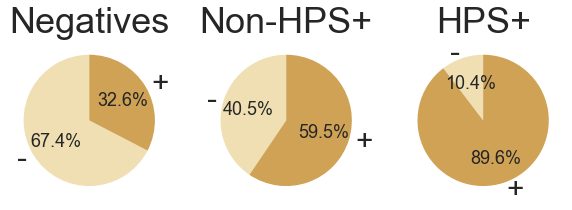

In [74]:
hpc_pie(tmp_df, 'conv_2_ad', path_results + 'adni1_mci_hpc_progression_pie.pdf')

## time to progression

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


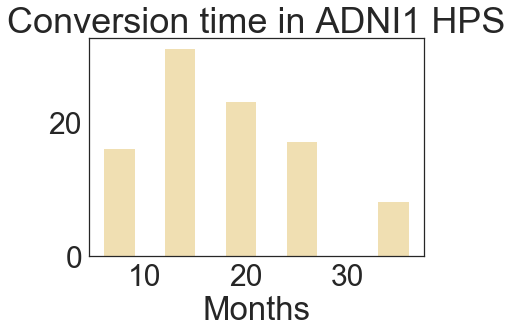

In [75]:
plt.hist(df2.dropna(subset=['Month_conv'])[df2.f_hpc==1]['Month_conv'].values)
plt.xlabel('Months')
plt.title('Conversion time in ADNI1 HPS')
plt.show()

## APOE4 positivity in ADNI1 MCI 

In [76]:
compare_ratio_var(df2, 'APOE4_bin', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.375
##########
baseline rate in TARGET subjects:  0.6870748299319728
##########
number of subjects with VOI in the whole sample:  134.0
total number of subjects with VOI data in whole sample:  235
ratio:  0.5702127659574469
##########
number of subjects with VOI that are positive at stage 1:  95.0
total number of positive stage 1 subjects with VOI data:  143
ratio:  0.6643356643356644
##########
number of subjects with VOI in HPC-AD:  72.0
total number of HPC-AD subjects with VOI data:  106
ratio:  0.6792452830188679
##########
number of subjects with VOI in Non-HPC+:  23.0
total number of Non-HPC+ with VOI data:  37
ratio:  0.6216216216216216
##########
number of subjects with VOI in negative subjects:  39.0
total number of negative subjects with VOI data 92
ratio:  0.42391304347826086


In [77]:
tmp_df = chi2_fn(df2, 'APOE4_bin')

observed freq: 
[[ 53.  14.  34.]
 [ 39.  23.  72.]]
Chi2:  13.5759311955
p value:  0.00112725974275
degress of freedom:  2
expected freq: 
[[ 39.54042553  15.90212766  45.55744681]
 [ 52.45957447  21.09787234  60.44255319]]


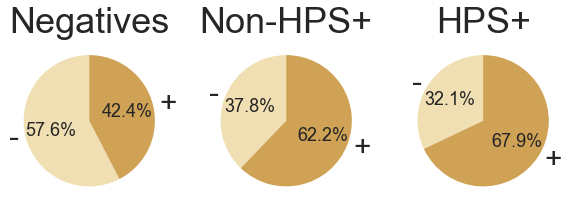

In [78]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_mci_hpc_e4_pie.pdf')

## sex (% male) in ADNI1 MCI

In [79]:
compare_ratio_var(df2, 'gender', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.5909090909090909
##########
baseline rate in TARGET subjects:  0.5918367346938775
##########
number of subjects with VOI in the whole sample:  139.0
total number of subjects with VOI data in whole sample:  235
ratio:  0.5914893617021276
##########
number of subjects with VOI that are positive at stage 1:  82.0
total number of positive stage 1 subjects with VOI data:  143
ratio:  0.5734265734265734
##########
number of subjects with VOI in HPC-AD:  63.0
total number of HPC-AD subjects with VOI data:  106
ratio:  0.5943396226415094
##########
number of subjects with VOI in Non-HPC+:  19.0
total number of Non-HPC+ with VOI data:  37
ratio:  0.5135135135135135
##########
number of subjects with VOI in negative subjects:  57.0
total number of negative subjects with VOI data 92
ratio:  0.6195652173913043


In [80]:
chi2_fn(df2, 'gender')

observed freq: 
[[ 35.  18.  43.]
 [ 57.  19.  63.]]
Chi2:  1.23473688028
p value:  0.53936193488
degress of freedom:  2
expected freq: 
[[ 37.58297872  15.11489362  43.30212766]
 [ 54.41702128  21.88510638  62.69787234]]


,HPS+,Negative,Non-HPS+,gender
0,43.0,35.0,18.0,-
1,63.0,57.0,19.0,+


## CSF tau in ADNI1 MCI 

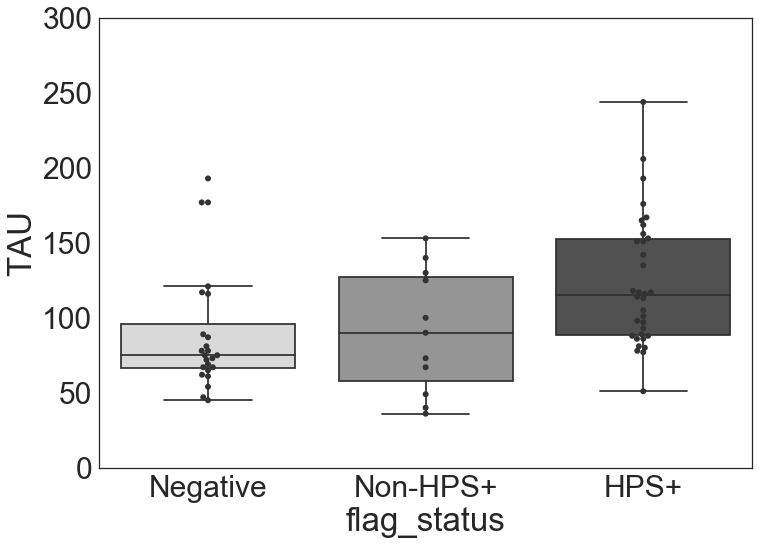

ANOVA F:  5.43197548265
p value:  0.00654787876694
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative -33.9363 -60.8386  -7.034  True 
  HPS+   Non-HPS+ -32.1711 -67.173   2.8307 False 
Negative Non-HPS+  1.7652  -34.976  38.5063 False 
--------------------------------------------------


In [81]:
anova_hpc(df2, 'TAU', 0, 300, path_results+'adni1_mci_csf_tau.pdf')

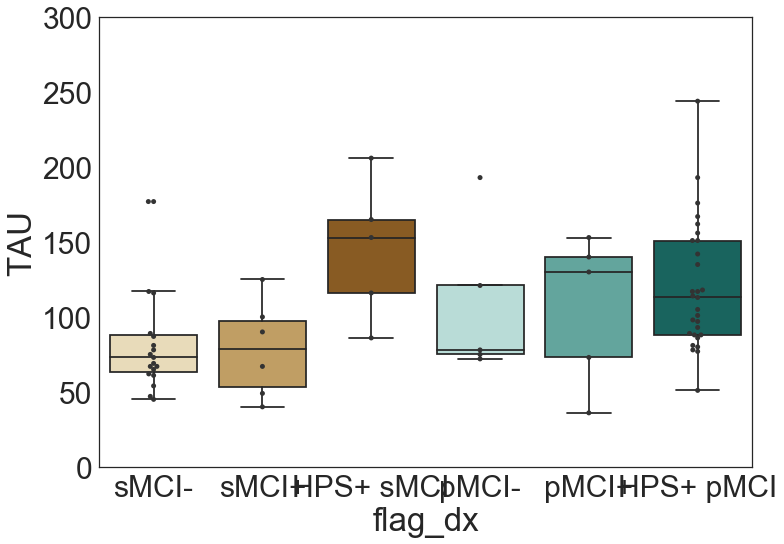

ANOVA F:  3.01657279759
p value:  0.0166898330421
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff   lower    upper  reject
-----------------------------------------------------
HPS+ pMCI HPS+ sMCI 25.6138   -33.8134  85.041 False 
HPS+ pMCI   pMCI+   -13.1862  -72.6134  46.241 False 
HPS+ pMCI   pMCI-   -11.7862  -71.2134  47.641 False 
HPS+ pMCI   sMCI+   -41.0862  -96.1275 13.9551 False 
HPS+ pMCI   sMCI-   -35.0073  -71.2294  1.2149 False 
HPS+ sMCI   pMCI+    -38.8   -116.4175 38.8175 False 
HPS+ sMCI   pMCI-    -37.4   -115.0175 40.2175 False 
HPS+ sMCI   sMCI+    -66.7   -141.0131  7.6131 False 
HPS+ sMCI   sMCI-   -60.6211 -122.3052  1.0631 False 
  pMCI+     pMCI-     1.4     -76.2175 79.0175 False 
  pMCI+     sMCI+    -27.9   -102.2131 46.4131 False 
  pMCI+     sMCI-   -21.8211  -83.5052 39.8631 False 
  pMCI-     sMCI+    -29.3   -103.6131 45.0131 False 
  pMCI-     sMCI-   -23.2211  -84.9052 38.4631 False 
  sMCI+     sMCI-    6.0789   -5

In [82]:
anova_hpc_split(df2, 'TAU', 0, 300, 'sMCI', 'pMCI', path_results + 'adni1_mci_csf_tau_split.pdf')

## CSF abeta in ADNI1 MCI 

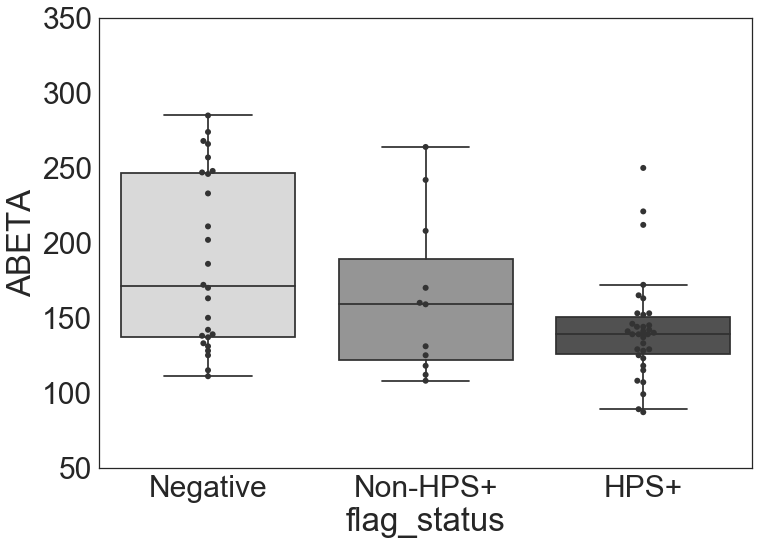

ANOVA F:  6.8960316846
p value:  0.00187552754356
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative 45.5769  16.1595  74.9944  True 
  HPS+   Non-HPS+ 21.3636  -17.8038 60.5311 False 
Negative Non-HPS+ -24.2133 -64.827  16.4005 False 
--------------------------------------------------


In [83]:
anova_hpc(df2, 'ABETA', 50, 350, path_results + 'adni1_mci_csf_abeta.pdf')

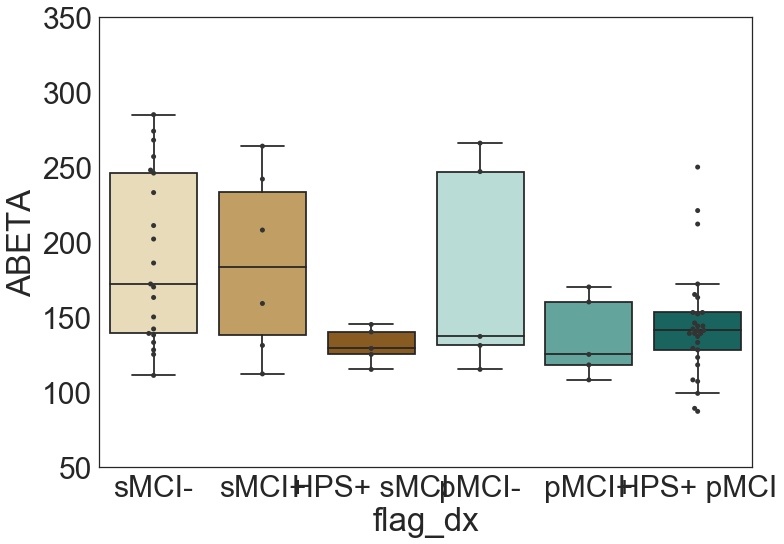

ANOVA F:  3.50374490458
p value:  0.00725786190432
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper   reject
-----------------------------------------------------
HPS+ pMCI HPS+ sMCI -13.131  -79.8412 53.5792  False 
HPS+ pMCI   pMCI+    -7.731  -74.4412 58.9792  False 
HPS+ pMCI   pMCI-    35.269  -31.4412 101.9792 False 
HPS+ pMCI   sMCI+    42.069  -19.7179 103.8558 False 
HPS+ pMCI   sMCI-   45.6404   6.1662  85.1146   True 
HPS+ sMCI   pMCI+     5.4    -81.7298 92.5298  False 
HPS+ sMCI   pMCI-     48.4   -38.7298 135.5298 False 
HPS+ sMCI   sMCI+     55.2   -28.2204 138.6204 False 
HPS+ sMCI   sMCI-   58.7714  -9.7819  127.3248 False 
  pMCI+     pMCI-     43.0   -44.1298 130.1298 False 
  pMCI+     sMCI+     49.8   -33.6204 133.2204 False 
  pMCI+     sMCI-   53.3714  -15.1819 121.9248 False 
  pMCI-     sMCI+     6.8    -76.6204 90.2204  False 
  pMCI-     sMCI-   10.3714  -58.1819 78.9248  False 
  sMCI+     sMCI-    3.5714  -6

In [84]:
anova_hpc_split(df2, 'ABETA', 50, 350, 'sMCI', 'pMCI', path_results + 'adni1_mci_csf_abeta_split.pdf')

## age in ADNI1 MCI 

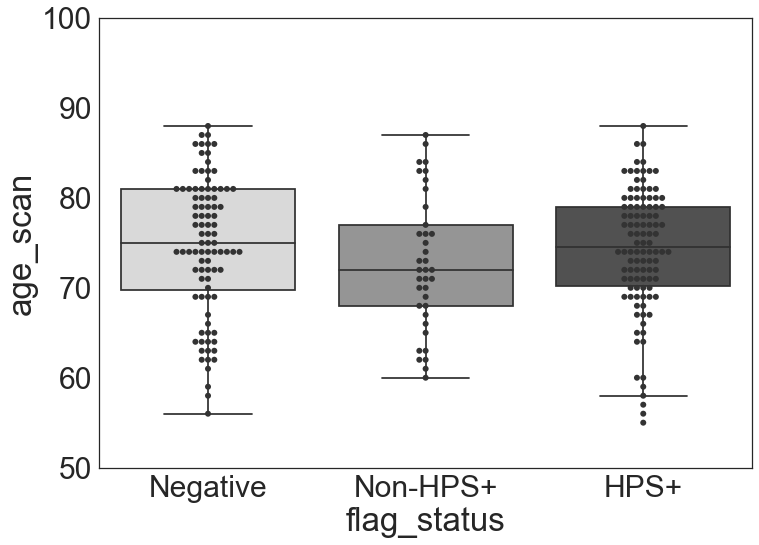

ANOVA F:  0.948741857027
p value:  0.388725012712
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.4707  -1.9789 2.9203 False 
  HPS+   Non-HPS+ -1.4791  -4.7617 1.8035 False 
Negative Non-HPS+ -1.9498  -5.2964 1.3969 False 
------------------------------------------------


In [85]:
anova_hpc(df2, 'age_scan', 50, 100, path_results + 'adni1_mci_age.pdf')

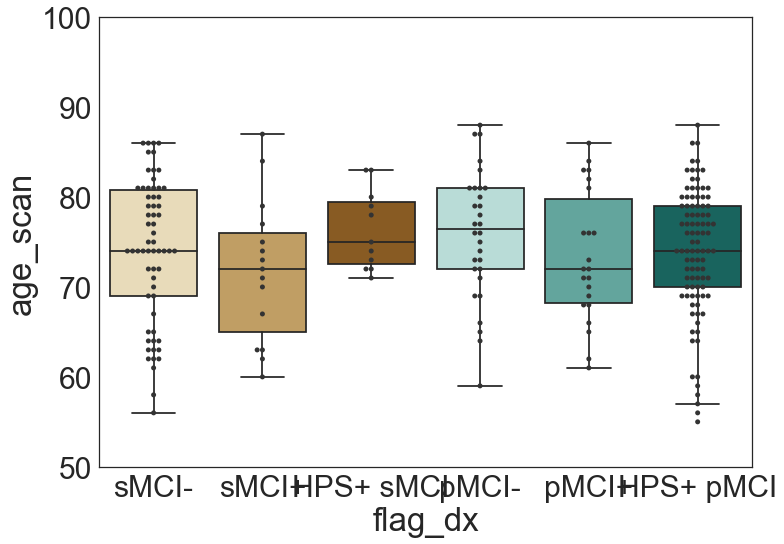

ANOVA F:  0.913226308947
p value:  0.473129284261
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
HPS+ pMCI HPS+ sMCI  2.3742  -4.3011  9.0494 False 
HPS+ pMCI   pMCI+   -0.5804  -5.5394  4.3786 False 
HPS+ pMCI   pMCI-    1.9105  -2.4789  6.2999 False 
HPS+ pMCI   sMCI+   -2.1895  -8.0127  3.6337 False 
HPS+ pMCI   sMCI-    0.1396  -3.2823  3.5614 False 
HPS+ sMCI   pMCI+   -2.9545  -10.6942 4.7851 False 
HPS+ sMCI   pMCI-   -0.4636  -7.8513  6.924  False 
HPS+ sMCI   sMCI+   -4.5636  -12.8835 3.7563 False 
HPS+ sMCI   sMCI-   -2.2346  -9.0917  4.6225 False 
  pMCI+     pMCI-    2.4909  -3.3921  8.374  False 
  pMCI+     sMCI+   -1.6091  -8.6272  5.409  False 
  pMCI+     sMCI-    0.7199  -4.4813  5.9212 False 
  pMCI-     sMCI+     -4.1   -10.7279 2.5279 False 
  pMCI-     sMCI-    -1.771  -6.4323  2.8904 False 
  sMCI+     sMCI-    2.329   -3.7018  8.3599 False 
--------------

In [86]:
anova_hpc_split(df2, 'age_scan', 50, 100, 'sMCI', 'pMCI', path_results + 'adni1_mci_age_split.pdf')

## associations of cognitive HPS with VBM subtypes in ADNI1 MCI

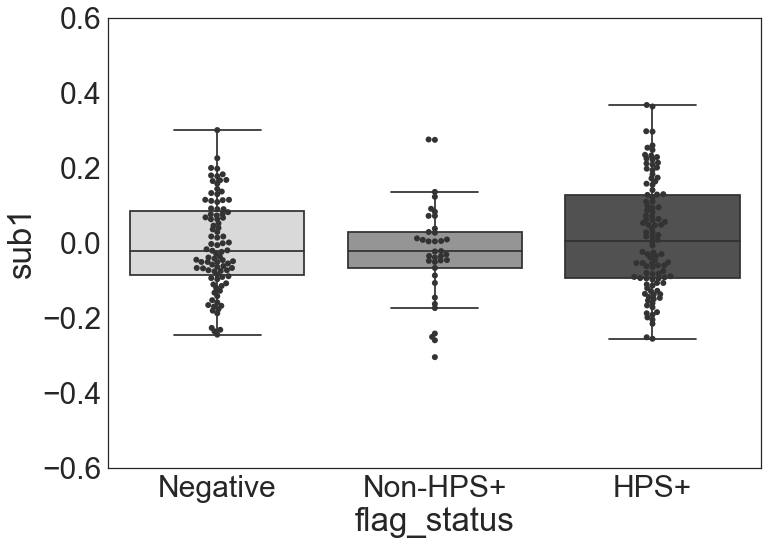

ANOVA F:  1.59728588203
p value:  0.204663374844
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -0.0235  -0.0687 0.0217 False 
  HPS+   Non-HPS+ -0.0422  -0.1027 0.0183 False 
Negative Non-HPS+ -0.0187  -0.0804 0.043  False 
------------------------------------------------


In [87]:
anova_hpc(df2, 'sub1', -0.6, 0.6, path_results + 'adni1_mci_sub1.pdf')

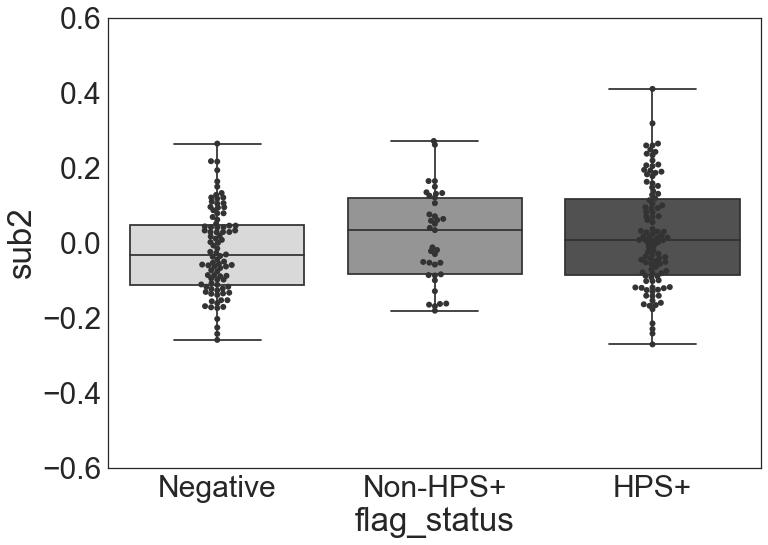

ANOVA F:  2.8503140687
p value:  0.0598532916497
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -0.0409  -0.0832 0.0015 False 
  HPS+   Non-HPS+ -0.0027  -0.0595 0.0541 False 
Negative Non-HPS+  0.0382  -0.0197 0.0961 False 
------------------------------------------------


In [88]:
anova_hpc(df2, 'sub2', -0.6, 0.6, path_results + 'adni1_mci_sub2.pdf')

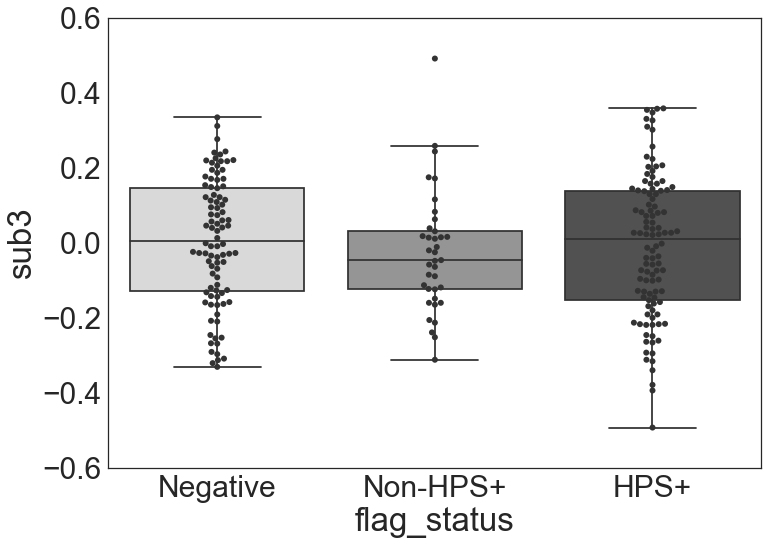

ANOVA F:  0.456455923228
p value:  0.6340926477
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0144  -0.0452 0.074  False 
  HPS+   Non-HPS+ -0.0177  -0.0975 0.0622 False 
Negative Non-HPS+ -0.0321  -0.1135 0.0494 False 
------------------------------------------------


In [89]:
anova_hpc(df2, 'sub3', -0.6, 0.6, path_results + 'adni1_mci_sub3.pdf')

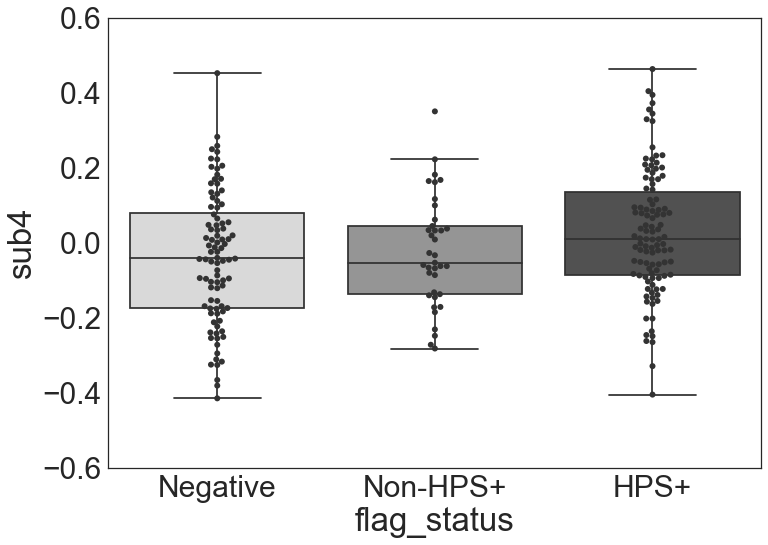

ANOVA F:  4.35006130871
p value:  0.0139750738579
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.0677  -0.1239 -0.0115  True 
  HPS+   Non-HPS+ -0.0551  -0.1304  0.0202 False 
Negative Non-HPS+  0.0126  -0.0642  0.0894 False 
-------------------------------------------------


In [90]:
anova_hpc(df2, 'sub4', -0.6, 0.6, path_results + 'adni1_mci_sub4.pdf')

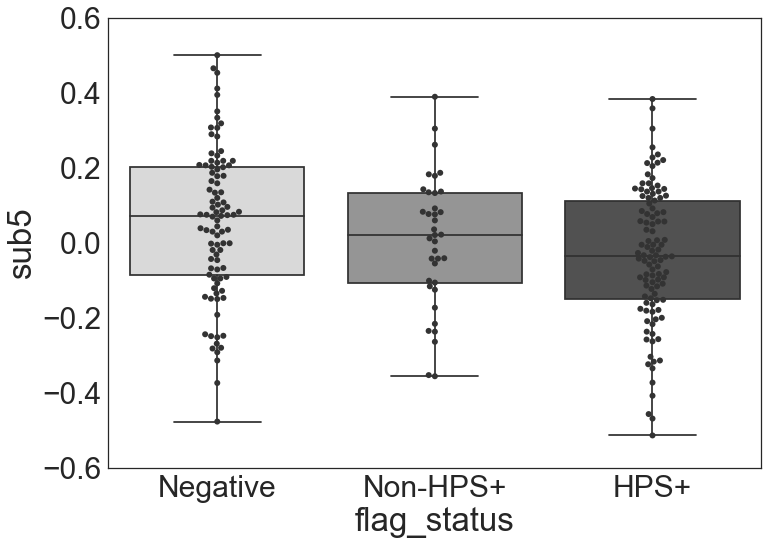

ANOVA F:  5.23132998131
p value:  0.00599517506515
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0867   0.0234 0.1499  True 
  HPS+   Non-HPS+  0.0378  -0.0469 0.1226 False 
Negative Non-HPS+ -0.0489  -0.1352 0.0375 False 
------------------------------------------------


In [91]:
anova_hpc(df2, 'sub5', -0.6, 0.6, path_results + 'adni1_mci_sub5.pdf')

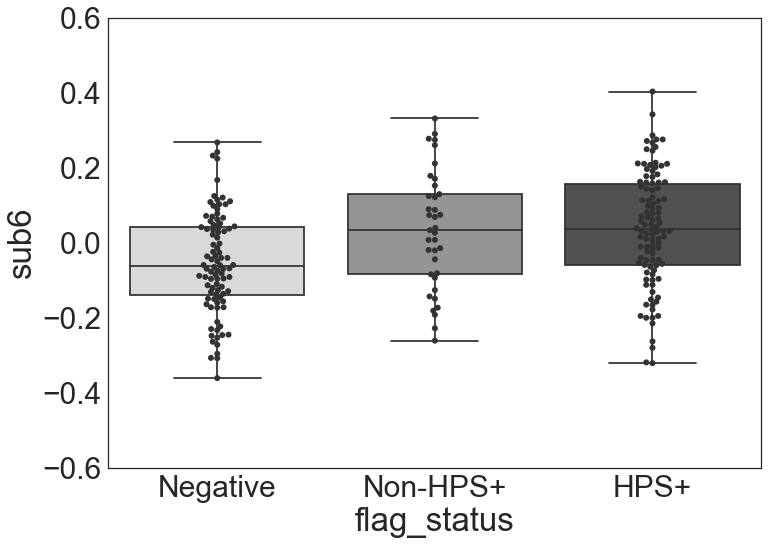

ANOVA F:  10.9505129687
p value:  2.85449563109e-05
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.0922   -0.141 -0.0433  True 
  HPS+   Non-HPS+ -0.0051  -0.0705  0.0604 False 
Negative Non-HPS+  0.0871   0.0203  0.1539  True 
-------------------------------------------------


In [92]:
anova_hpc(df2, 'sub6', -0.6, 0.6, path_results + 'adni1_mci_sub6.pdf')

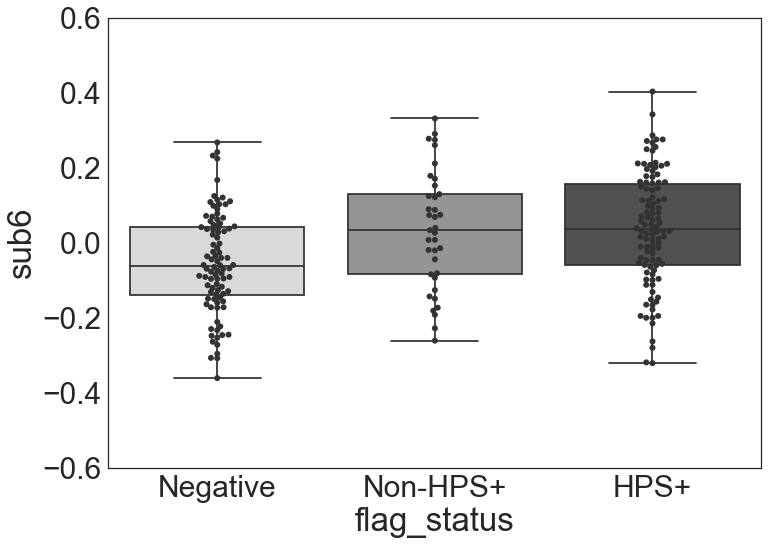

ANOVA F:  10.9505129687
p value:  2.85449563109e-05
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.0922   -0.141 -0.0433  True 
  HPS+   Non-HPS+ -0.0051  -0.0705  0.0604 False 
Negative Non-HPS+  0.0871   0.0203  0.1539  True 
-------------------------------------------------


In [93]:
anova_hpc(df2, 'sub6', -0.6, 0.6, path_results + 'adni1_mci_sub7.pdf')

# REPLICATION IN ADNI2 

In [94]:
adni2_df = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_model_weights.csv')

In [95]:
adni2_df.drop(adni2_df[adni2_df.RID < 2000].index,inplace=True)

In [96]:
# get rid of NaNs
adni2_df.dropna(axis=0,how='any',subset=['sub1','gender','age_scan','mean_gm','tiv','conv_2_ad',
                                        'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],inplace=True)

In [97]:
adni2_df = adni2_df[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
            'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX',
                    'sub1','sub2','sub3','sub4','sub5','sub6','sub7']]

## AD vs CN 

In [98]:
# Mask of the AD and CN subjects only
mask_cnad = adni2_df.loc[:,['CN','AD']].values.sum(1).astype(bool)

x_ = adni2_df.iloc[mask_cnad,adni2_df.columns.get_loc("ADAS13"):adni2_df.columns.get_loc("CLOCKSCOR")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_df[['AD']].values.ravel()[mask_cnad]


confounds = adni2_df[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((276, 9), (276,), (276, 4))

In [99]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  88.0
# true values:  276
ACC  :  0.95652173913
Level 2
------------------------
Ratio: 0.886363636364
#    :  78.0
# true values:  79
ACC  :  0.987341772152


In [100]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [101]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  88.0
Total number of NON-TARGET subjects:  188.0
Stage 1 number of hits (true and false positives):  90.0
Stage 1 TRUE positives:  83.0
Stage 1 FALSE positives:  7.0
Stage 1 TRUE negatives:  181.0
Total number of flagged HPC-AD subjects:  79.0
Number of flagged HPC-AD subjects that are TRUE positives:  78.0
Number of flagged HPC-AD subjects that are FALSE positives:  1.0
Number of true negatives:  187.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.922222222222
Recall (or sensitivity)  for AD:  0.943181818182
Specificity:  0.962765957447
Adjusted precision for 33.6% baseline rate:  0.927631578947
Accuracy:  0.95652173913
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.987341772152
Recall (or sensitivity) for HPC-AD:  0.886363636364
Specificity:  0.994680851064
Adjusted precision for 33.6% baseline rate:  0.988279695503
Accuracy:  0.960144927536


(0.94318181818181823,
 0.96276595744680848,
 0.92222222222222228,
 0.95652173913043481,
 0.88636363636363635,
 0.99468085106382975,
 0.98734177215189878,
 0.96014492753623193)

In [102]:
# copy data frame and mask
df3 = deepcopy(adni2_df)
df3 = df3[mask_cnad]

In [103]:
hpc_df(df3, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [104]:
long_df_adni3_adcn = pd.merge(long_data, df3[['RID','flag_dx','flag_status']], 
                              how='left', on=['RID'])

In [105]:
long_df_adni3_adcn.dropna(subset=['flag_status'],inplace=True)

In [106]:
long_df_adni3_adcn.reset_index(inplace=True, drop=True)

In [107]:
long_df_adni3_adcn.to_csv(path_results + 'adni2_adcn_hps.csv', index=False)

## apoe4 carriership in ADNI2 AD vs CN

In [108]:
compare_ratio_var(df3, 'APOE4_bin', 'AD')

baseline rate in NON-TARGET subjects:  0.29411764705882354
##########
baseline rate in TARGET subjects:  0.7093023255813954
##########
number of subjects with VOI in the whole sample:  116.0
total number of subjects with VOI data in whole sample:  273
ratio:  0.4249084249084249
##########
number of subjects with VOI that are positive at stage 1:  57.0
total number of positive stage 1 subjects with VOI data:  88
ratio:  0.6477272727272727
##########
number of subjects with VOI in HPC-AD:  53.0
total number of HPC-AD subjects with VOI data:  77
ratio:  0.6883116883116883
##########
number of subjects with VOI in Non-HPC+:  4.0
total number of Non-HPC+ with VOI data:  11
ratio:  0.36363636363636365
##########
number of subjects with VOI in negative subjects:  59.0
total number of negative subjects with VOI data 185
ratio:  0.31891891891891894


In [109]:
tmp_df = chi2_fn(df3, 'APOE4_bin')

observed freq: 
[[ 126.    7.   24.]
 [  59.    4.   53.]]
Chi2:  30.5363624491
p value:  2.33944664845e-07
degress of freedom:  2
expected freq: 
[[ 106.39194139    6.32600733   44.28205128]
 [  78.60805861    4.67399267   32.71794872]]


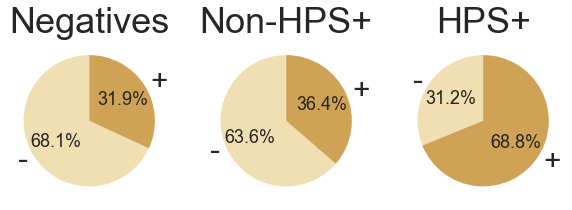

In [110]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni2_adcn_hpc_e4_pie.pdf')

## gender (% male) in ADNI2 AD VS CN

In [111]:
compare_ratio_var(df3, 'gender', 'AD')

baseline rate in NON-TARGET subjects:  0.4574468085106383
##########
baseline rate in TARGET subjects:  0.5454545454545454
##########
number of subjects with VOI in the whole sample:  134.0
total number of subjects with VOI data in whole sample:  276
ratio:  0.4855072463768116
##########
number of subjects with VOI that are positive at stage 1:  48.0
total number of positive stage 1 subjects with VOI data:  90
ratio:  0.5333333333333333
##########
number of subjects with VOI in HPC-AD:  43.0
total number of HPC-AD subjects with VOI data:  79
ratio:  0.5443037974683544
##########
number of subjects with VOI in Non-HPC+:  5.0
total number of Non-HPC+ with VOI data:  11
ratio:  0.45454545454545453
##########
number of subjects with VOI in negative subjects:  86.0
total number of negative subjects with VOI data 186
ratio:  0.46236559139784944


In [112]:
chi2_fn(df3, 'gender')

observed freq: 
[[ 100.    6.   36.]
 [  86.    5.   43.]]
Chi2:  1.53433072109
p value:  0.464327405379
degress of freedom:  2
expected freq: 
[[ 95.69565217   5.65942029  40.64492754]
 [ 90.30434783   5.34057971  38.35507246]]


,HPS+,Negative,Non-HPS+,gender
0,36.0,100.0,6.0,-
1,43.0,86.0,5.0,+


## associations with vbm subtypes

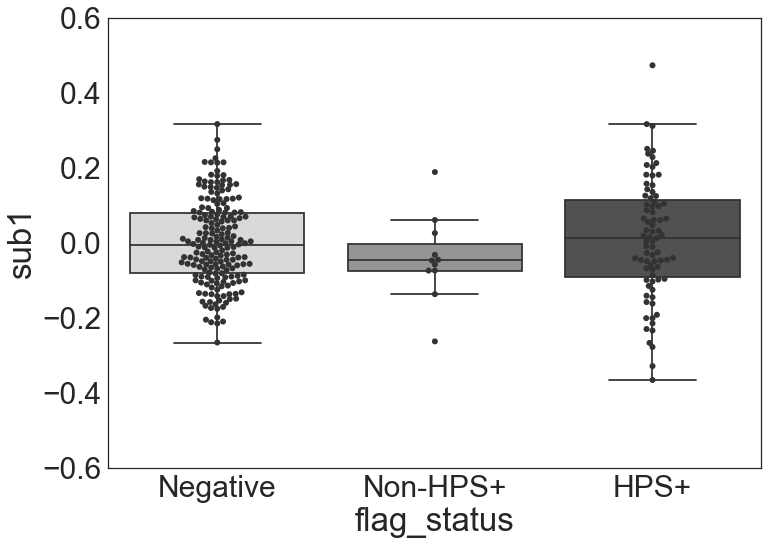

ANOVA F:  0.833619295616
p value:  0.435576815565
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -0.0095  -0.0499 0.0308 False 
  HPS+   Non-HPS+ -0.0524  -0.1491 0.0443 False 
Negative Non-HPS+ -0.0428  -0.1361 0.0504 False 
------------------------------------------------


In [113]:
anova_hpc(df3, 'sub1', -0.6, 0.6, path_results + 'adni2_adcn_sub1.pdf')

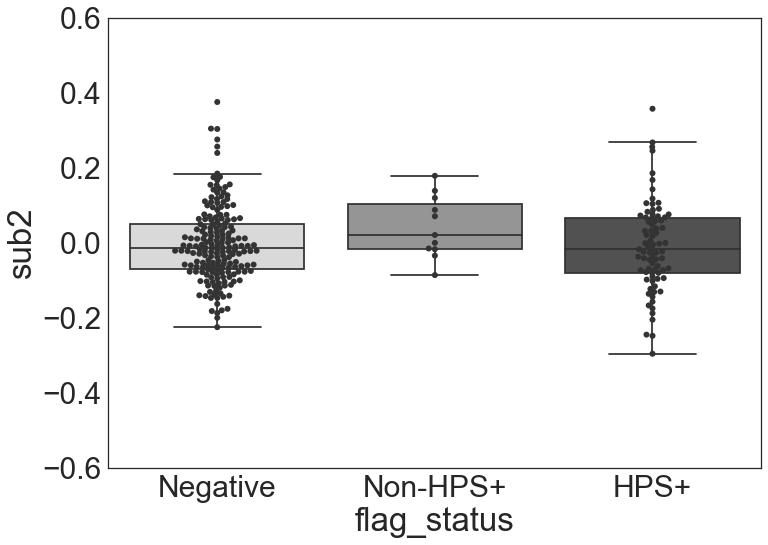

ANOVA F:  1.18243356242
p value:  0.308096719025
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0072  -0.0263 0.0407 False 
  HPS+   Non-HPS+  0.0523  -0.0279 0.1325 False 
Negative Non-HPS+  0.0451  -0.0322 0.1225 False 
------------------------------------------------


In [114]:
anova_hpc(df3, 'sub2', -0.6, 0.6, path_results + 'adni2_adcn_sub2.pdf')

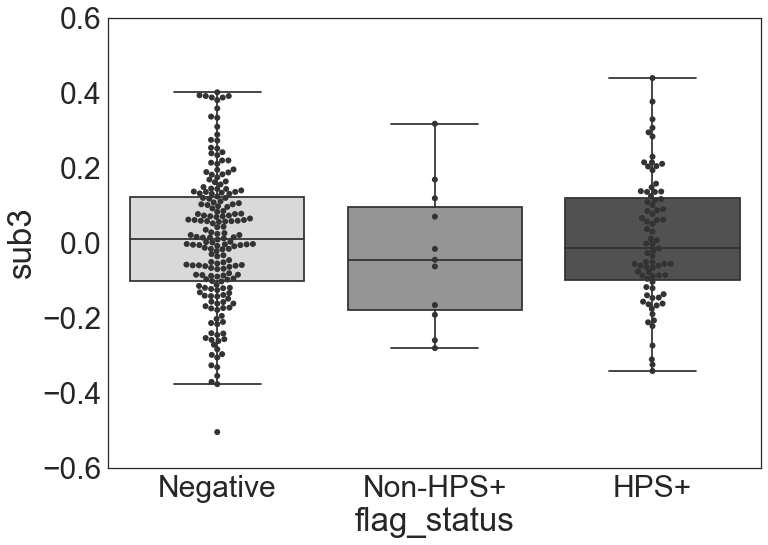

ANOVA F:  0.289583304547
p value:  0.748805083976
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0018   -0.053 0.0566 False 
  HPS+   Non-HPS+ -0.0391  -0.1704 0.0922 False 
Negative Non-HPS+ -0.0409  -0.1675 0.0858 False 
------------------------------------------------


In [115]:
anova_hpc(df3, 'sub3', -0.6, 0.6, path_results + 'adni2_adcn_sub3.pdf')

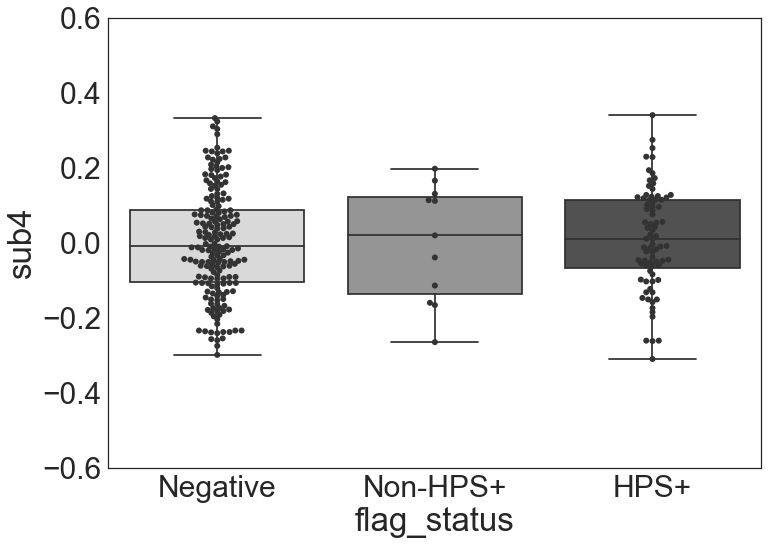

ANOVA F:  0.126741381991
p value:  0.881013281061
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -0.0093  -0.0537 0.0352 False 
  HPS+   Non-HPS+ -0.0113  -0.1179 0.0952 False 
Negative Non-HPS+ -0.0021  -0.1049 0.1007 False 
------------------------------------------------


In [116]:
anova_hpc(df3, 'sub4', -0.6, 0.6, path_results + 'adni2_adcn_sub4.pdf')

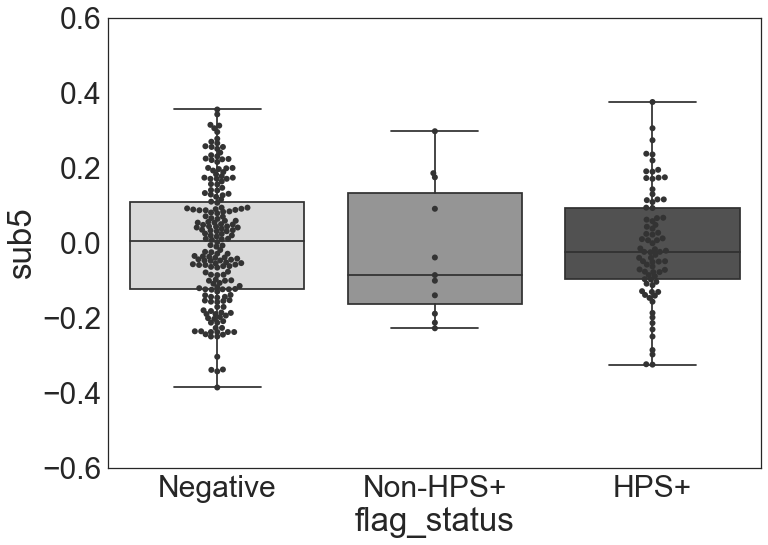

ANOVA F:  0.139985149754
p value:  0.869433508433
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0071  -0.0427 0.0569 False 
  HPS+   Non-HPS+ -0.0148  -0.1342 0.1045 False 
Negative Non-HPS+ -0.0219   -0.137 0.0931 False 
------------------------------------------------


In [117]:
anova_hpc(df3, 'sub5', -0.6, 0.6, path_results + 'adni2_adcn_sub5.pdf')

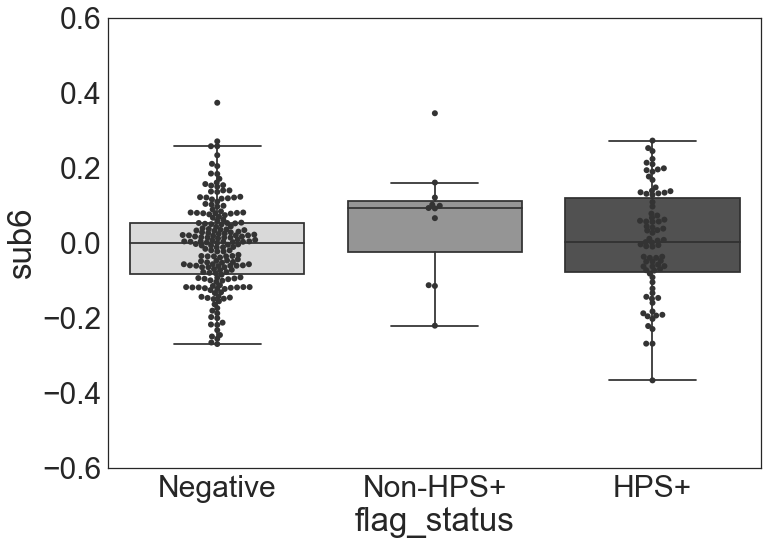

ANOVA F:  1.64855056612
p value:  0.194237239
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -0.0116  -0.0506 0.0275 False 
  HPS+   Non-HPS+  0.0555   -0.038 0.1491 False 
Negative Non-HPS+  0.0671  -0.0231 0.1573 False 
------------------------------------------------


In [118]:
anova_hpc(df3, 'sub6', -0.6, 0.6, path_results + 'adni2_adcn_sub6.pdf')

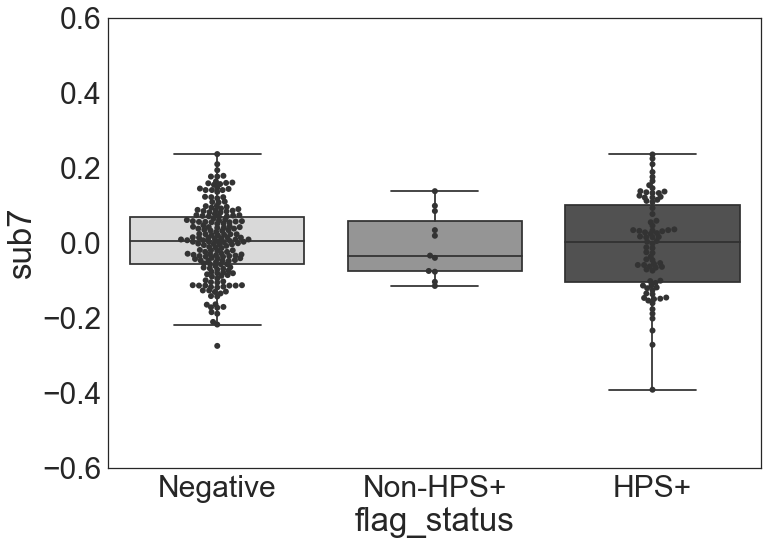

ANOVA F:  0.315209372642
p value:  0.72990127983
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0108  -0.0221 0.0436 False 
  HPS+   Non-HPS+  0.0017   -0.077 0.0805 False 
Negative Non-HPS+  -0.009   -0.085 0.0669 False 
------------------------------------------------


In [119]:
anova_hpc(df3, 'sub7', -0.6, 0.6, path_results + 'adni2_adcn_sub7.pdf')

## csf abeta in ADNI2 AD VS CN

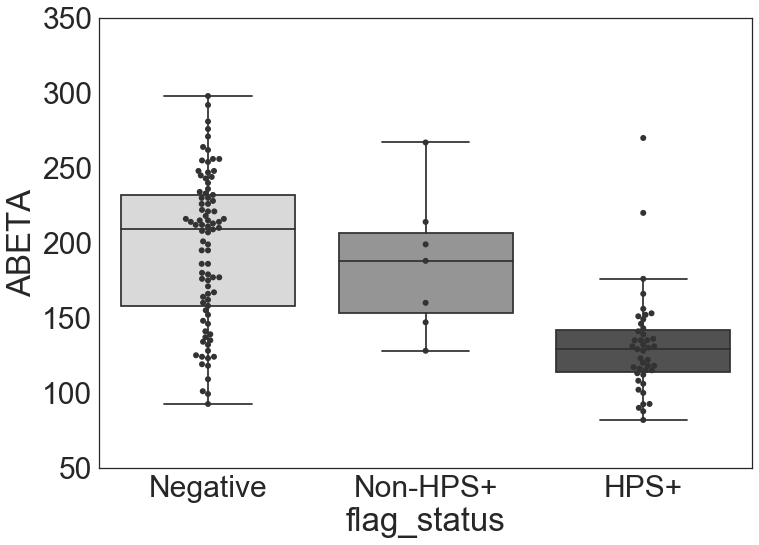

ANOVA F:  29.7747911843
p value:  2.12480772557e-11
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative 65.0553  44.9921 85.1185  True 
  HPS+   Non-HPS+ 55.1429  11.4469 98.8388  True 
Negative Non-HPS+ -9.9124   -52.07 32.2451 False 
-------------------------------------------------


In [120]:
anova_hpc(df3, 'ABETA', 50, 350, path_results + 'adni2_adcn_csf_abeta.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


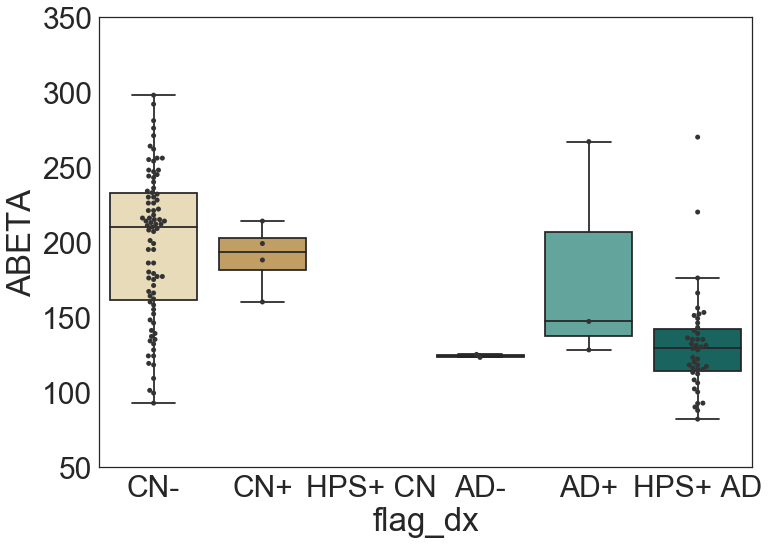

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff   lower    upper   reject
-------------------------------------------------
 AD+     AD-   -56.6667 -169.4321 56.0987  False 
 AD+     CN+    9.5833   -84.763  103.9296 False 
 AD+     CN-   17.1249   -55.4717 89.7215  False 
 AD+   HPS+ AD -49.6667 -123.4317 24.0984  False 
 AD-     CN+    66.25    -40.7286 173.2286 False 
 AD-     CN-   73.7916   -14.6022 162.1854 False 
 AD-   HPS+ AD   7.0     -82.356   96.356  False 
 CN+     CN-    7.5416   -55.6934 70.7765  False 
 CN+   HPS+ AD  -59.25   -123.823  5.323   False 
 CN-   HPS+ AD -66.7916  -90.0017 -43.5814  True 
-------------------------------------------------


In [121]:
anova_hpc_split(df3, 'ABETA', 50, 350, 'CN', 'AD', path_results + 'adni2_adcn_csf_abeta_split.pdf')

##  csf tau in ADNI2 AD VS CN

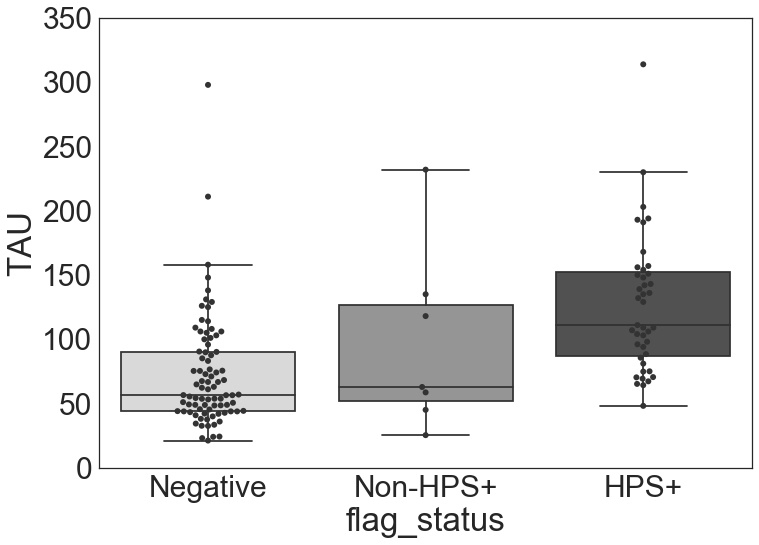

ANOVA F:  17.6732242541
p value:  1.62424402776e-07
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative -58.0277 -81.1836 -34.8717  True 
  HPS+   Non-HPS+ -34.0635 -84.2923 16.1654  False 
Negative Non-HPS+ 23.9642  -24.5406  72.469  False 
---------------------------------------------------


In [122]:
anova_hpc(df3, 'TAU', 0, 350, path_results + 'adni2_adcn_csf_tau.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


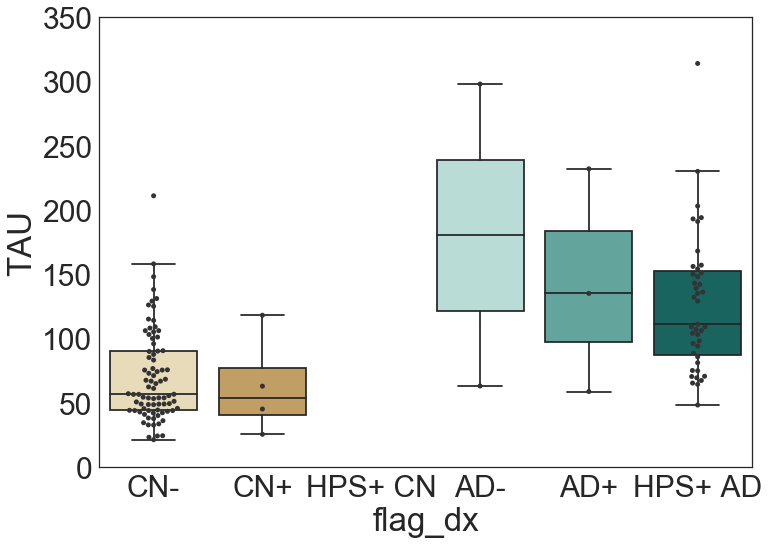

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2  meandiff   lower    upper   reject
--------------------------------------------------
 AD+     AD-    38.5833   -87.0643 164.2309 False 
 AD+     CN+    -79.0917  -184.216 26.0327  False 
 AD+     CN-    -71.8198 -152.7445  9.105   False 
 AD+   HPS+ AD  -11.1318  -93.3237 71.0601  False 
 AD-     CN+    -117.675 -236.8748  1.5248  False 
 AD-     CN-   -110.4031 -208.9235 -11.8826  True 
 AD-   HPS+ AD  -49.7151  -149.279 49.8488  False 
 CN+     CN-     7.2719   -63.2269 77.7707  False 
 CN+   HPS+ AD  67.9599   -3.9899  139.9097 False 
 CN-   HPS+ AD   60.688   34.7176  86.6584   True 
--------------------------------------------------


In [123]:
anova_hpc_split(df3, 'TAU', 0, 350, 'CN', 'AD', path_results + 'adni2_adcn_csf_tau_split.pdf')

## age in ADNI2 AD VS CN

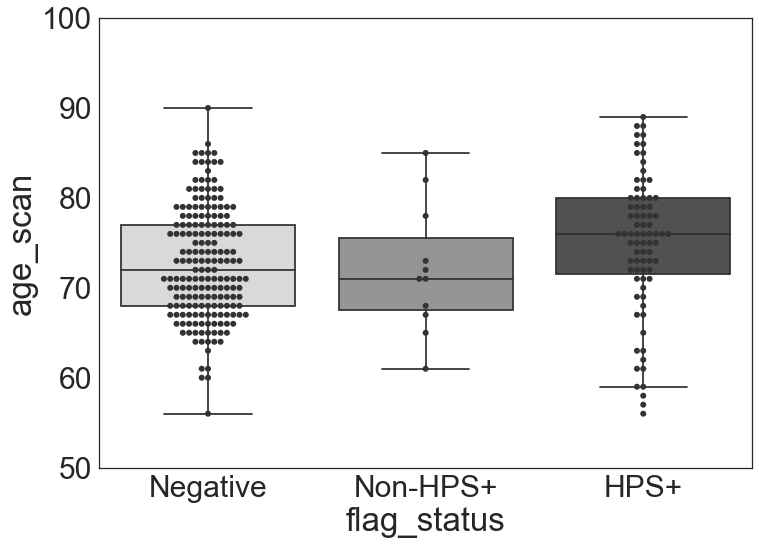

ANOVA F:  2.99876170627
p value:  0.0514936640657
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  -2.135  -4.2577 -0.0122  True 
  HPS+   Non-HPS+ -2.7699  -7.8568  2.3171 False 
Negative Non-HPS+ -0.6349  -5.5398   4.27  False 
-------------------------------------------------


In [124]:
anova_hpc(df3, 'age_scan', 50, 100, path_results + 'adni2_adcn_age.pdf')

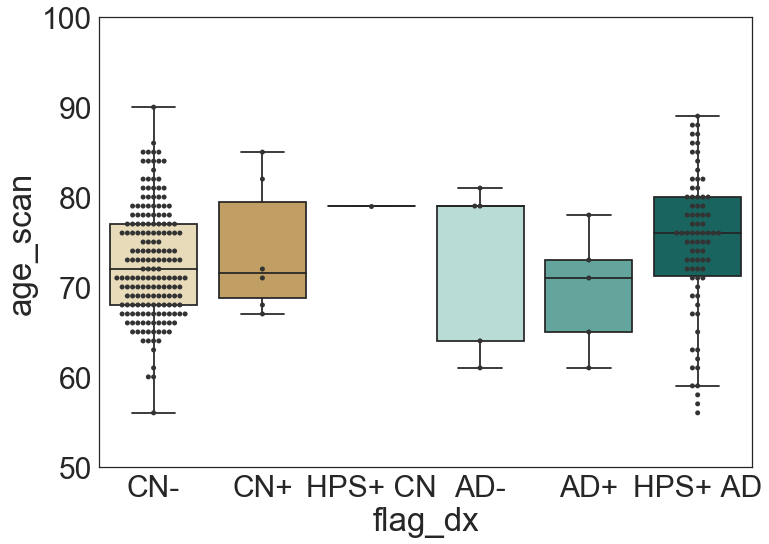

ANOVA F:  1.52202623521
p value:  0.183072259708
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper  reject
------------------------------------------------
  AD+     AD-     3.2    -9.0062  15.4062 False 
  AD+     CN+    4.5667  -7.1199  16.2532 False 
  AD+     CN-    3.1238  -5.6257  11.8733 False 
  AD+   HPS+ AD  5.2077  -3.6957  14.1111 False 
  AD+   HPS+ CN   9.4    -11.7418 30.5418 False 
  AD-     CN+    1.3667  -10.3199 13.0532 False 
  AD-     CN-   -0.0762  -8.8257   8.6733 False 
  AD-   HPS+ AD  2.0077  -6.8957  10.9111 False 
  AD-   HPS+ CN   6.2    -14.9418 27.3418 False 
  CN+     CN-   -1.4429  -9.4515   6.5657 False 
  CN+   HPS+ AD  0.641   -7.5355   8.8175 False 
  CN+   HPS+ CN  4.8333  -16.0127 25.6794 False 
  CN-   HPS+ AD  2.0839  -0.5301   4.698  False 
  CN-   HPS+ CN  6.2762  -13.0767 25.6292 False 
HPS+ AD HPS+ CN  4.1923  -15.2307 23.6153 False 
------------------------------------------------


In [125]:
anova_hpc_split(df3, 'age_scan', 50, 100, 'CN', 'AD', path_results + 'adni2_adcn_age_split.pdf')

## MCI stable vs converters

In [126]:
adni2_mci = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_mci_bl_demog_weights.csv')

In [127]:
mask_mci = adni2_mci.loc[:,'MCI'].values.astype(bool)
adni2_mci = adni2_mci.iloc[mask_mci]

In [128]:
adni2_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv',
                        'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],inplace=True)

In [129]:
adni2_mci = adni2_mci[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
            'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX','Month_conv',
                      'sub1','sub2','sub3','sub4','sub5','sub6','sub7']]

In [130]:
x_ = adni2_mci.iloc[:, adni2_mci.columns.get_loc("ADAS13"):adni2_mci.columns.get_loc("CLOCKSCOR")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_mci[['conv_2_ad']].values.ravel()


confounds = adni2_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((235, 9), (235,), (235, 4))

In [131]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  55.0
# true values:  235
ACC  :  0.842553191489
Level 2
------------------------
Ratio: 0.563636363636
#    :  31.0
# true values:  40
ACC  :  0.775


In [132]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [133]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  55.0
Total number of NON-TARGET subjects:  180.0
Stage 1 number of hits (true and false positives):  60.0
Stage 1 TRUE positives:  39.0
Stage 1 FALSE positives:  21.0
Stage 1 TRUE negatives:  159.0
Total number of flagged HPC-AD subjects:  40.0
Number of flagged HPC-AD subjects that are TRUE positives:  31.0
Number of flagged HPC-AD subjects that are FALSE positives:  9.0
Number of true negatives:  171.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.65
Recall (or sensitivity)  for AD:  0.709090909091
Specificity:  0.883333333333
Adjusted precision for 33.6% baseline rate:  0.754635850578
Accuracy:  0.842553191489
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.775
Recall (or sensitivity) for HPC-AD:  0.563636363636
Specificity:  0.95
Adjusted precision for 33.6% baseline rate:  0.85084136579
Accuracy:  0.859574468085


(0.70909090909090911,
 0.8833333333333333,
 0.65000000000000002,
 0.8425531914893617,
 0.5636363636363636,
 0.94999999999999996,
 0.77500000000000002,
 0.8595744680851064)

In [134]:
# copy data frame and mask
df4 = deepcopy(adni2_mci)

In [135]:
hpc_df(df4, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [136]:
df4.to_csv(path_results + 'adni2_mci_hps.csv', index=False)

In [137]:
tmp_df4 = pd.merge(df4, long_data[['RID','ABETA','TAU','ADAS13','DX_bl']],
              how='left', on=['RID','ABETA','TAU','ADAS13'])

In [138]:
df4 = tmp_df4

## late  MCI

In [139]:
# make dummy variable for LMCI
for i,row in df4.iterrows():
    dx = row['DX_bl']
    if dx == 'EMCI':
        df4.ix[i,'l_mci'] = 0
    if dx == 'LMCI':
        df4.ix[i,'l_mci'] = 1

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [140]:
tmp_df = chi2_fn(df4, 'l_mci')

observed freq: 
[[ 171.   10.    9.]
 [  49.   15.   34.]]
Chi2:  59.9145007187
p value:  9.76633182418e-14
degress of freedom:  2
expected freq: 
[[ 145.13888889   16.49305556   28.36805556]
 [  74.86111111    8.50694444   14.63194444]]


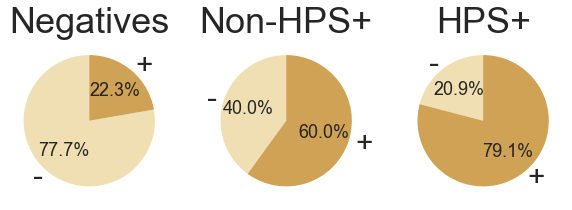

In [141]:
hpc_pie(tmp_df, 'l_mci', path_results + 'adni2_mci_hpc_lmci.pdf')

## % progressors

In [142]:
tmp_df = chi2_fn(df4, 'conv_2_ad')

observed freq: 
[[ 201.   16.   10.]
 [  19.    9.   33.]]
Chi2:  103.545832808
p value:  3.27572996678e-23
degress of freedom:  2
expected freq: 
[[ 173.40277778   19.70486111   33.89236111]
 [  46.59722222    5.29513889    9.10763889]]


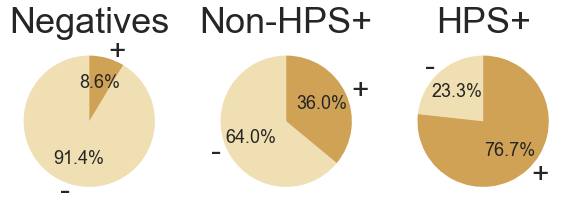

In [143]:
hpc_pie(tmp_df, 'conv_2_ad', path_results + 'adni2_mci_hpc_progressors.pdf')

## time to progression 

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


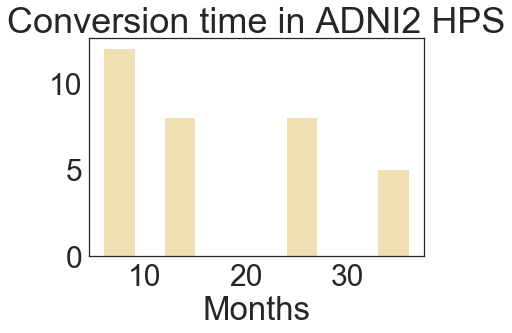

In [144]:
plt.hist(df4.dropna(subset=['Month_conv'])[df4.f_hpc==1]['Month_conv'].values)
plt.xlabel('Months')
plt.title('Conversion time in ADNI2 HPS')
plt.show()

## apoe4 carriership in ADNI2 MCI

In [145]:
compare_ratio_var(df4, 'APOE4_bin', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.3524229074889868
##########
baseline rate in TARGET subjects:  0.6557377049180327
##########
number of subjects with VOI in the whole sample:  120.0
total number of subjects with VOI data in whole sample:  288
ratio:  0.4166666666666667
##########
number of subjects with VOI that are positive at stage 1:  36.0
total number of positive stage 1 subjects with VOI data:  68
ratio:  0.5294117647058824
##########
number of subjects with VOI in HPC-AD:  24.0
total number of HPC-AD subjects with VOI data:  43
ratio:  0.5581395348837209
##########
number of subjects with VOI in Non-HPC+:  12.0
total number of Non-HPC+ with VOI data:  25
ratio:  0.48
##########
number of subjects with VOI in negative subjects:  84.0
total number of negative subjects with VOI data 220
ratio:  0.38181818181818183


In [146]:
tmp_df = chi2_fn(df4, 'APOE4_bin')

observed freq: 
[[ 136.   13.   19.]
 [  84.   12.   24.]]
Chi2:  5.05265599517
p value:  0.0799520661041
degress of freedom:  2
expected freq: 
[[ 128.33333333   14.58333333   25.08333333]
 [  91.66666667   10.41666667   17.91666667]]


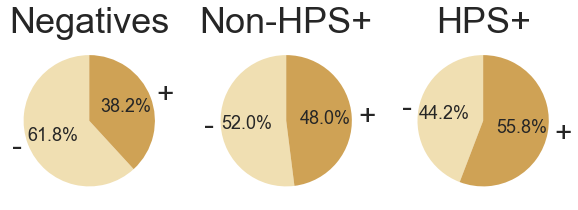

In [147]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni2_mci_hpc_e4_pie.pdf')

## gender (% male) in ADNI2 MCI 

In [148]:
compare_ratio_var(df4, 'gender', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.5242290748898678
##########
baseline rate in TARGET subjects:  0.5245901639344263
##########
number of subjects with VOI in the whole sample:  151.0
total number of subjects with VOI data in whole sample:  288
ratio:  0.5243055555555556
##########
number of subjects with VOI that are positive at stage 1:  36.0
total number of positive stage 1 subjects with VOI data:  68
ratio:  0.5294117647058824
##########
number of subjects with VOI in HPC-AD:  25.0
total number of HPC-AD subjects with VOI data:  43
ratio:  0.5813953488372093
##########
number of subjects with VOI in Non-HPC+:  11.0
total number of Non-HPC+ with VOI data:  25
ratio:  0.44
##########
number of subjects with VOI in negative subjects:  115.0
total number of negative subjects with VOI data 220
ratio:  0.5227272727272727


In [149]:
chi2_fn(df4, 'gender')

observed freq: 
[[ 105.   14.   18.]
 [ 115.   11.   25.]]
Chi2:  1.27654130102
p value:  0.528205085855
degress of freedom:  2
expected freq: 
[[ 104.65277778   11.89236111   20.45486111]
 [ 115.34722222   13.10763889   22.54513889]]


,HPS+,Negative,Non-HPS+,gender
0,18.0,105.0,14.0,-
1,25.0,115.0,11.0,+


## age in ADNI2 MCI 

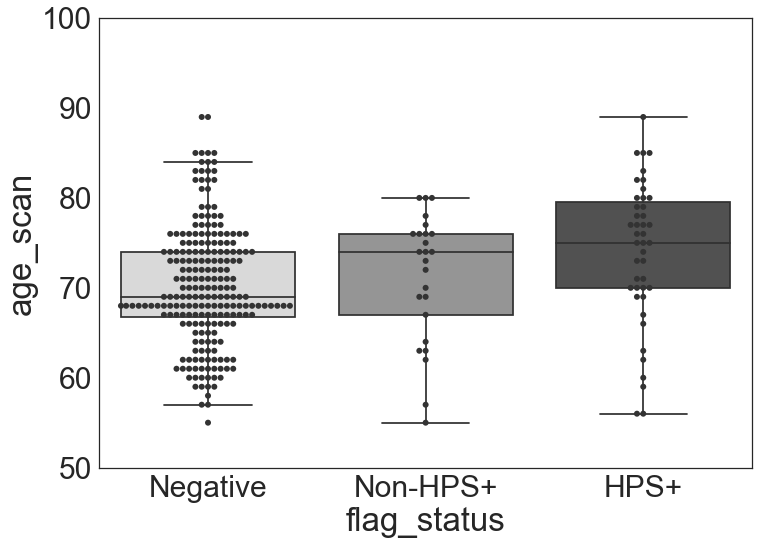

ANOVA F:  5.15231533555
p value:  0.00633695906591
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -3.6762  -6.3811 -0.9714  True 
  HPS+   Non-HPS+ -2.7535  -6.8335  1.3265 False 
Negative Non-HPS+  0.9227  -2.5011  4.3465 False 
-------------------------------------------------


In [150]:
anova_hpc(df4, 'age_scan', 50, 100, path_results + 'adni2_mci_age.pdf')

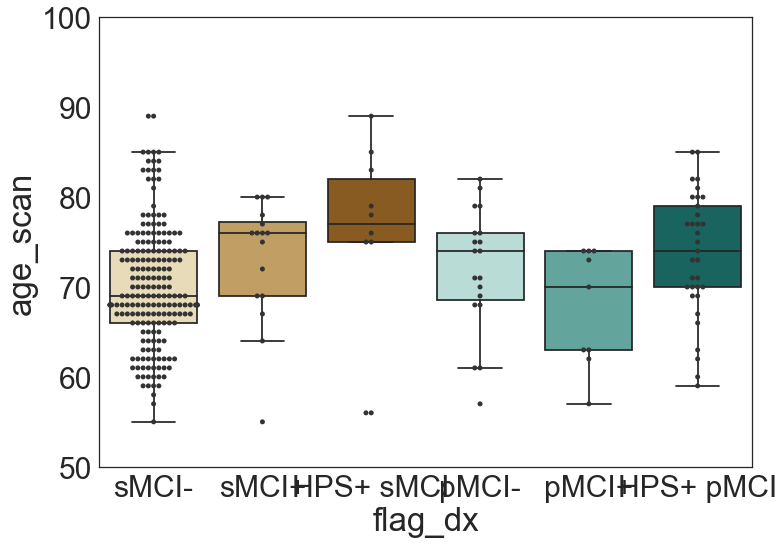

ANOVA F:  3.10936831817
p value:  0.00948844209547
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper  reject
----------------------------------------------------
HPS+ pMCI HPS+ sMCI  1.6242  -5.4802   8.7287 False 
HPS+ pMCI   pMCI+    -5.798  -13.1992  1.6032 False 
HPS+ pMCI   pMCI-   -1.6284  -7.2963   4.0395 False 
HPS+ pMCI   sMCI+   -0.4508  -6.4464   5.5449 False 
HPS+ pMCI   sMCI-   -3.4564   -7.153   0.2403 False 
HPS+ sMCI   pMCI+   -7.4222  -16.4652  1.6207 False 
HPS+ sMCI   pMCI-   -3.2526  -10.9418  4.4365 False 
HPS+ sMCI   sMCI+    -2.075  -10.0088  5.8588 False 
HPS+ sMCI   sMCI-   -5.0806  -11.4573  1.2961 False 
  pMCI+     pMCI-    4.1696  -3.7945  12.1337 False 
  pMCI+     sMCI+    5.3472  -2.8533  13.5478 False 
  pMCI+     sMCI-    2.3416  -4.3641   9.0473 False 
  pMCI-     sMCI+    1.1776  -5.5005   7.8557 False 
  pMCI-     sMCI-    -1.828  -6.5518   2.8958 False 
  sMCI+     sMCI-   -3.0056   -8.118   2.1068 Fa

In [151]:
anova_hpc_split(df4, 'age_scan', 50, 100, 'sMCI', 'pMCI', path_results + 'adni2_mci_age_split.pdf')

## csf abeta in ADNI2 MCI

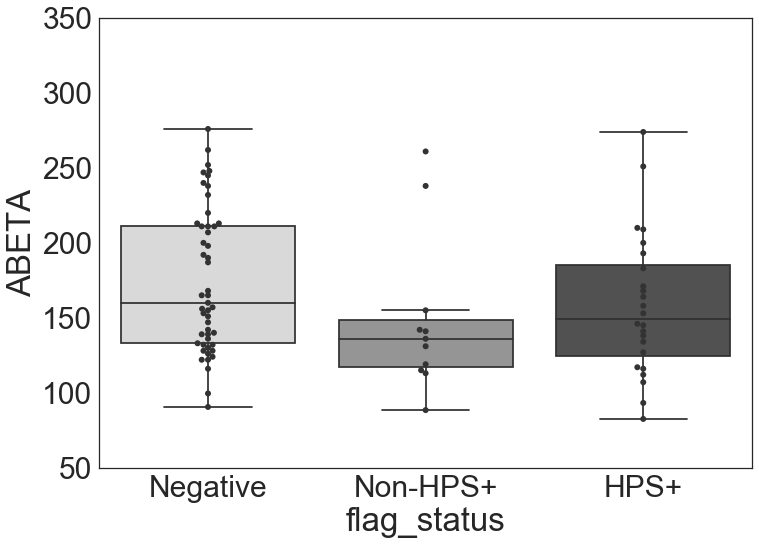

ANOVA F:  1.73687844421
p value:  0.182561830789
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative 16.4402  -12.4418 45.3222 False 
  HPS+   Non-HPS+ -8.9928  -51.2014 33.2158 False 
Negative Non-HPS+ -25.433  -64.1098 13.2438 False 
--------------------------------------------------


In [152]:
anova_hpc(df4, 'ABETA', 50, 350, path_results + 'adni2_mci_csf_abeta.pdf')

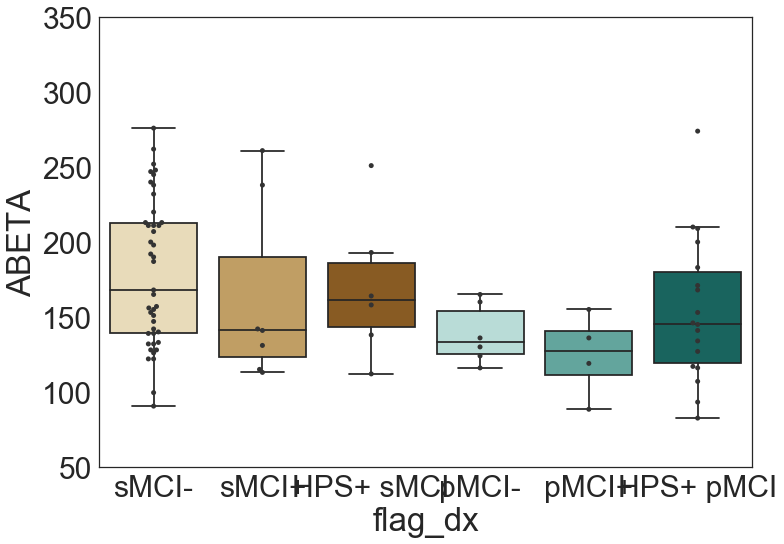

ANOVA F:  1.91880955898
p value:  0.100627437507
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1    group2  meandiff   lower    upper   reject
------------------------------------------------------
HPS+ pMCI HPS+ sMCI 15.0722   -50.596  80.7404  False 
HPS+ pMCI   pMCI+   -29.6611 -106.6639 47.3417  False 
HPS+ pMCI   pMCI-   -15.7611  -81.4293 49.9071  False 
HPS+ pMCI   sMCI+    8.7389   -53.3117 70.7895  False 
HPS+ pMCI   sMCI-   25.2273   -13.8798 64.3344  False 
HPS+ sMCI   pMCI+   -44.7333 -134.6532 45.1865  False 
HPS+ sMCI   pMCI-   -30.8333 -111.2601 49.5934  False 
HPS+ sMCI   sMCI+   -6.3333   -83.8345 71.1678  False 
HPS+ sMCI   sMCI-    10.155   -50.5535 70.8635  False 
  pMCI+     pMCI-     13.9    -76.0199 103.8199 False 
  pMCI+     sMCI+     38.4    -48.9129 125.7129 False 
  pMCI+     sMCI-   54.8884   -17.9308 127.7076 False 
  pMCI-     sMCI+     24.5    -53.0012 102.0012 False 
  pMCI-     sMCI-   40.9884   -19.7201 101.6969 False 
  sMCI+     sMCI

In [153]:
anova_hpc_split(df4, 'ABETA', 50, 350, 'sMCI', 'pMCI', path_results + 'adni2_mci_csf_abeta_split.pdf')

## csf tau in ADNI2 MCI

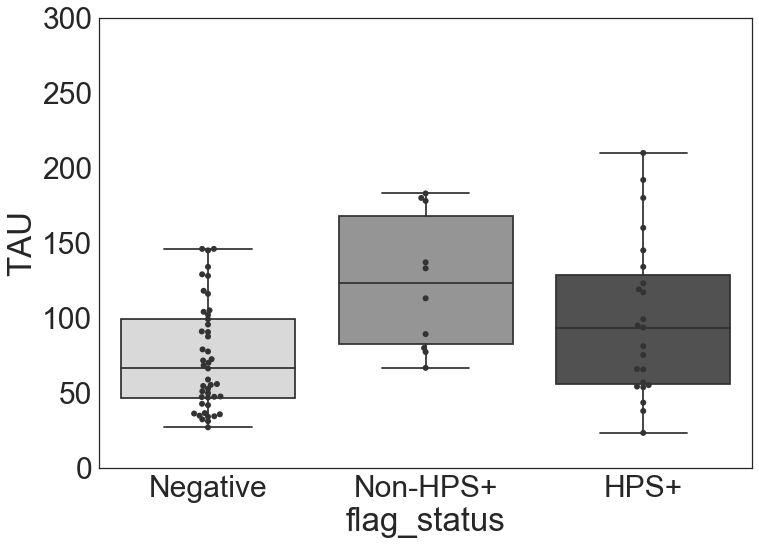

ANOVA F:  7.1172513965
p value:  0.00147848550847
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative -25.9091 -51.8003 -0.0179  True 
  HPS+   Non-HPS+ 24.5887  -13.6727 62.8501 False 
Negative Non-HPS+ 50.4978  15.1841  85.8115  True 
--------------------------------------------------


In [154]:
anova_hpc(df4, 'TAU', 0, 300, path_results + 'adni2_mci_csf_tau.pdf')

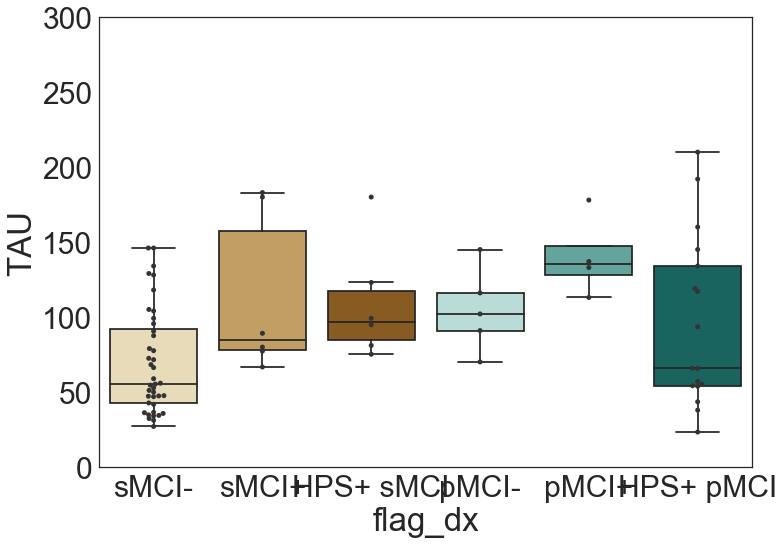

ANOVA F:  3.85369413394
p value:  0.00376861055645
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1    group2  meandiff   lower    upper   reject
------------------------------------------------------
HPS+ pMCI HPS+ sMCI 13.1804   -44.8917 71.2525  False 
HPS+ pMCI   pMCI+   44.5971   -23.3638 112.558  False 
HPS+ pMCI   pMCI-    9.1271   -53.0895 71.3436  False 
HPS+ pMCI   sMCI+   16.9804   -41.0917 75.0525  False 
HPS+ pMCI   sMCI-   -26.4204  -61.8273  8.9864  False 
HPS+ sMCI   pMCI+   31.4167   -47.5236 110.3569 False 
HPS+ sMCI   pMCI-   -4.0533   -78.1058 69.9992  False 
HPS+ sMCI   sMCI+     3.8     -66.8063 74.4063  False 
HPS+ sMCI   sMCI-   -39.6008  -93.1407  13.939  False 
  pMCI+     pMCI-    -35.47  -117.5071 46.5671  False 
  pMCI+     sMCI+   -27.6167 -106.5569 51.3236  False 
  pMCI+     sMCI-   -71.0175 -135.1488 -6.8862   True 
  pMCI-     sMCI+    7.8533   -66.1992 81.9058  False 
  pMCI-     sMCI-   -35.5475  -93.5565 22.4615  False 
  sMCI+     sM

In [155]:
anova_hpc_split(df4, 'TAU', 0, 300, 'sMCI', 'pMCI', path_results + 'adni2_mci_csf_tau_split.pdf')

## associations with VBM subtypes

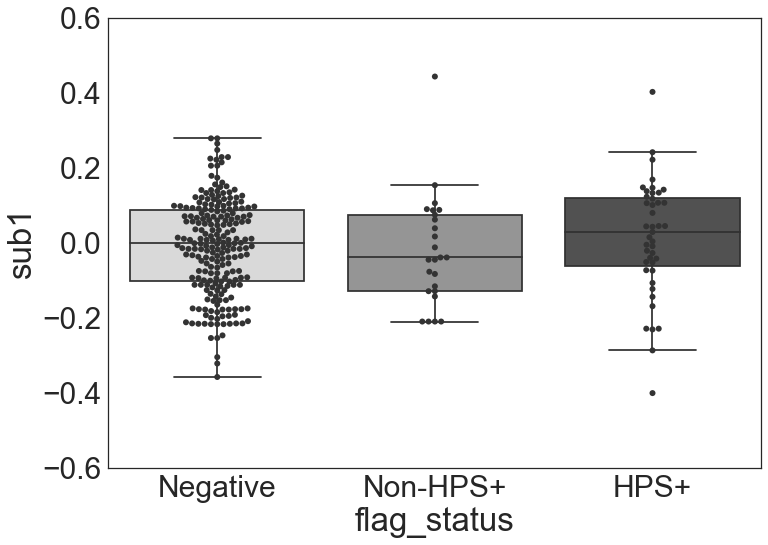

ANOVA F:  0.682458270109
p value:  0.506197048756
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -0.0232  -0.0753 0.0289 False 
  HPS+   Non-HPS+ -0.0337  -0.1124 0.0449 False 
Negative Non-HPS+ -0.0106  -0.0765 0.0554 False 
------------------------------------------------


In [156]:
anova_hpc(df4, 'sub1', -0.6, 0.6, path_results + 'adni2_mci_sub1.pdf')

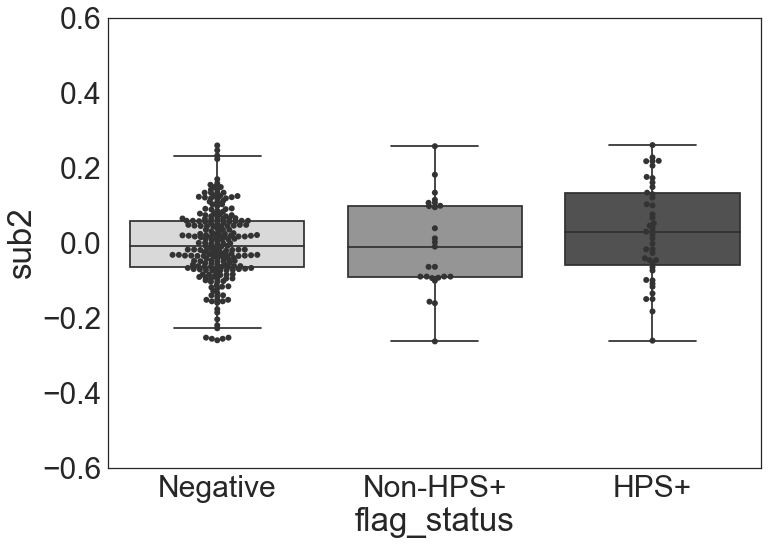

ANOVA F:  2.2419665957
p value:  0.108120072839
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -0.0364  -0.0771 0.0043 False 
  HPS+   Non-HPS+ -0.0345  -0.0959 0.0269 False 
Negative Non-HPS+  0.0019  -0.0496 0.0534 False 
------------------------------------------------


In [157]:
anova_hpc(df4, 'sub2', -0.6, 0.6, path_results + 'adni2_mci_sub2.pdf')

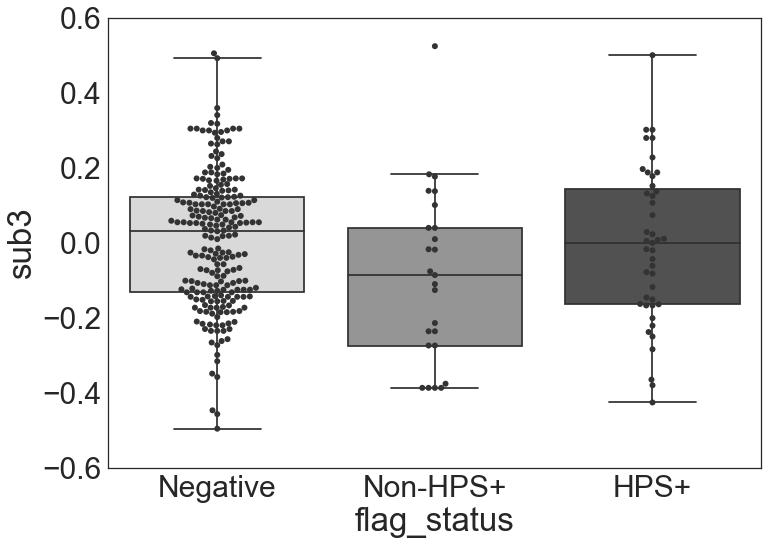

ANOVA F:  3.01698535872
p value:  0.050514666562
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative  0.0134  -0.0595  0.0862 False 
  HPS+   Non-HPS+ -0.0827  -0.1925  0.0272 False 
Negative Non-HPS+  -0.096  -0.1882 -0.0038  True 
-------------------------------------------------


In [158]:
anova_hpc(df4, 'sub3', -0.6, 0.6, path_results + 'adni2_mci_sub3.pdf')

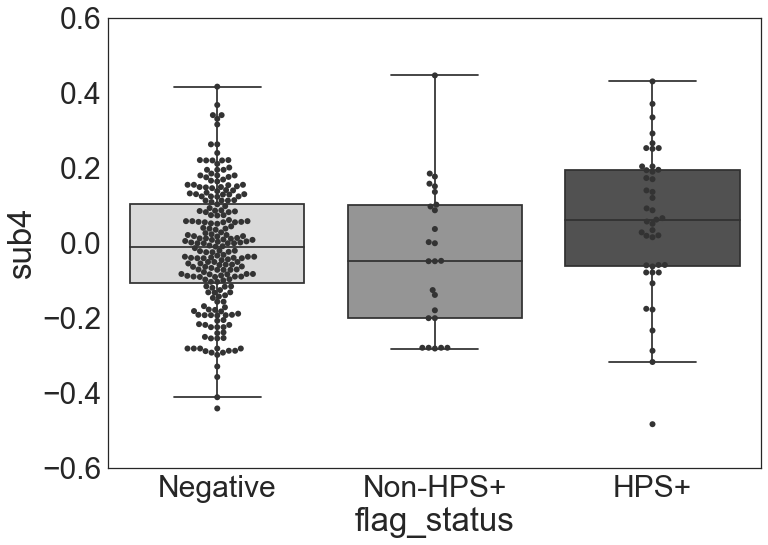

ANOVA F:  3.68289364891
p value:  0.0263547664228
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.0714  -0.1367 -0.0061  True 
  HPS+   Non-HPS+ -0.0895   -0.188  0.009  False 
Negative Non-HPS+ -0.0182  -0.1008  0.0645 False 
-------------------------------------------------


In [159]:
anova_hpc(df4, 'sub4', -0.6, 0.6, path_results + 'adni2_mci_sub4.pdf')

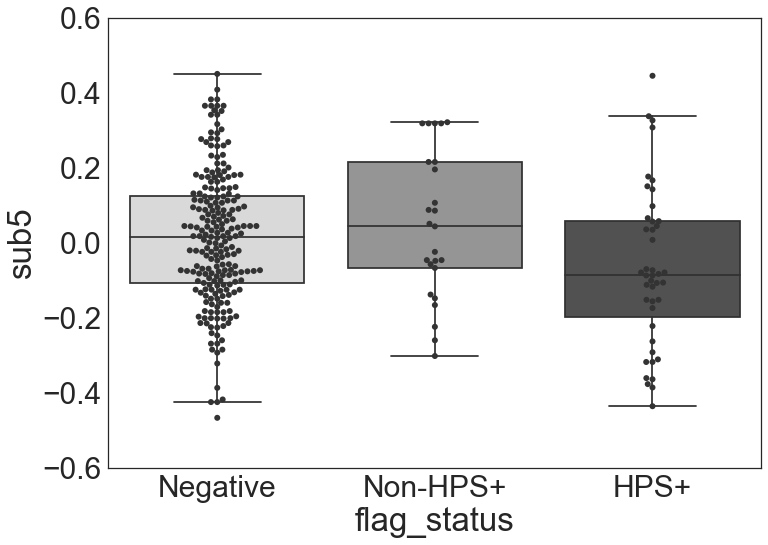

ANOVA F:  4.05450893151
p value:  0.0183541537387
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0801   0.0078 0.1525  True 
  HPS+   Non-HPS+  0.111    0.0019 0.2202  True 
Negative Non-HPS+  0.0309  -0.0607 0.1225 False 
------------------------------------------------


In [160]:
anova_hpc(df4, 'sub5', -0.6, 0.6, path_results + 'adni2_mci_sub5.pdf')

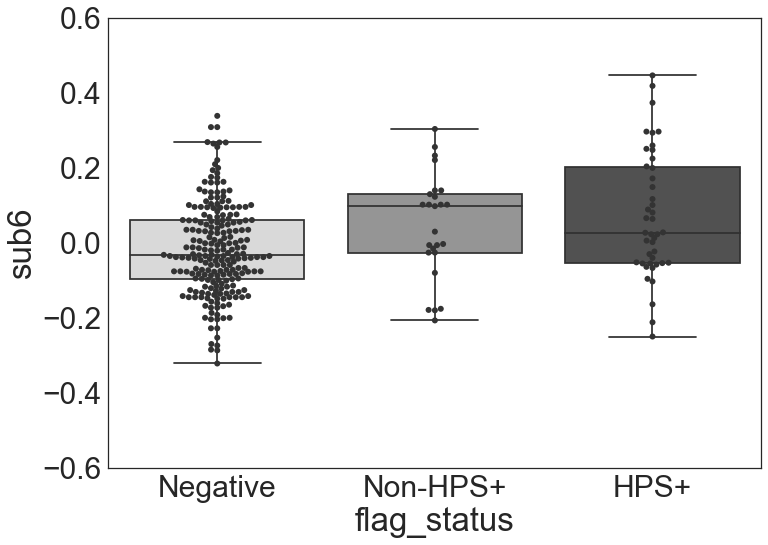

ANOVA F:  10.0261428723
p value:  6.19522599579e-05
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -0.0893  -0.1407 -0.0379  True 
  HPS+   Non-HPS+  -0.025  -0.1025  0.0526 False 
Negative Non-HPS+  0.0644  -0.0007  0.1294 False 
-------------------------------------------------


In [161]:
anova_hpc(df4, 'sub6', -0.6, 0.6, path_results + 'adni2_mci_sub6.pdf')

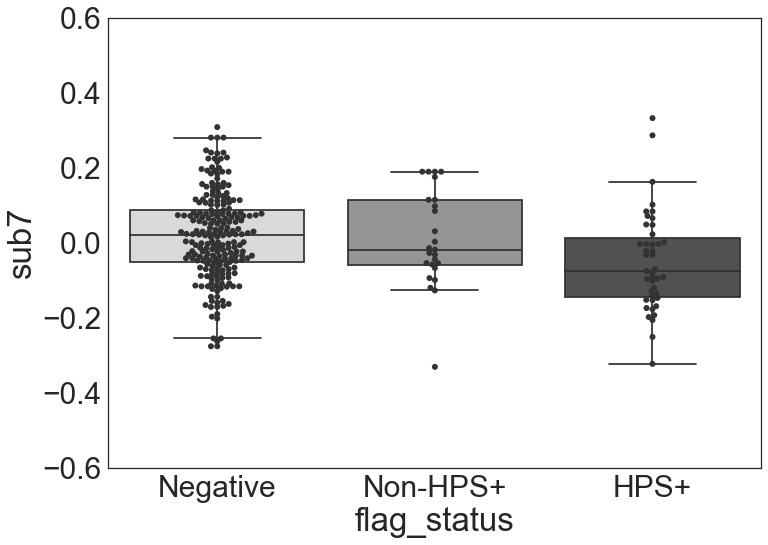

ANOVA F:  6.19403070758
p value:  0.00232696335864
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.0696   0.023  0.1163  True 
  HPS+   Non-HPS+  0.0603   -0.01  0.1307 False 
Negative Non-HPS+ -0.0093  -0.0683 0.0497 False 
------------------------------------------------


In [162]:
anova_hpc(df4, 'sub7', -0.6, 0.6, path_results + 'adni2_mci_sub7.pdf')